In [15]:
# Core
import re, os, glob, sys, string
import pandas as pd
from pathlib import Path
from itertools import cycle, islice, combinations
import numpy as np
# Plotting
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.ticker import MultipleLocator
from matplotlib import colors as mcolors
from matplotlib import colorbar
import seaborn as sns
# Phylogenetics
from ete3 import Tree, TreeStyle, TextFace,NodeStyle,faces, COLOR_SCHEMES
import toytree
import toyplot
import toyplot.pdf
import toyplot.png
import dendropy as dp

Following Matt Johnson's [Phyparts Pie Charts notebook](https://github.com/mossmatters/MJPythonNotebooks/blob/master/PhyParts_PieCharts.ipynb). First grab all of the relevant files.

# Final concordance analysis
## Rerooting trees

### Jump to concordance analysis if already completed.

In [4]:
working_dir = Path("/Users/iangilman/Dropbox/Dipsacales_Baits_Project/Gene-tree-investigation/FINAL_SPECIES_TREE/")
unrooted_sptree_path = working_dir / "Dipsacales-species-tree.BS33.unrooted.tre"
genetreespath = working_dir / "Dipsacales-gene-trees.BS33.unrooted.trees"

Reroot the species tree and export the topology.

In [4]:
with open(working_dir / "Dipsacales-species-tree.BS33.rooted.topology.tre", "w+") as r:
    with open(unrooted_sptree_path, "r") as s:
        sptree = Tree(s.readline())
    sptree.set_outgroup("Ilex_crenata")
    r.write(sptree.write(format=9))
with open(working_dir / "Dipsacales-species-tree.BS33.rooted.tre", "w+") as r:
    r.write(sptree.write())

Reroot each of the gene trees to *Ilex*, or *Paracryhia* if *Ilex* is not in the tree, and then we'll deal with the trees that can't easily be rooted after

In [5]:
with open(working_dir/"Dipsacales-gene-trees.BS33.rooted.trees", "w+") as r:
    rooted = []
    problems = []
    with open(genetreespath, "r") as g:
        for line in g.readlines():
            genetree = Tree(line)
            if "Ilex_crenata" in genetree.get_leaf_names():
                genetree.set_outgroup("Ilex_crenata")
                rooted.append(genetree.write()+"\n")
            elif "Paracryphia_alticola" in genetree.get_leaf_names():
                genetree.set_outgroup("Paracryphia_alticola")
                rooted.append(genetree.write()+"\n")
            else:
                problems.append(genetree)
    r.writelines(rooted)
print("{} gene trees were easily rooted".format(len(rooted)))
print("{} gene trees will need to be manually rooted".format(len(problems)))

218 gene trees were easily rooted
9 gene trees will need to be manually rooted


In [6]:
fixed = []

In [7]:
genetree = problems[0]
genetree.set_outgroup("Viburnum_vernicosum")
genetree.render("%%inline")

fixed.append(genetree.write()+"\n")

In [209]:
genetree = problems[1]
genetree.set_outgroup("Viburnum_jamesonii")
genetree.render("%%inline")

fixed.append(genetree.write()+"\n")

In [210]:
genetree = problems[2]
genetree.set_outgroup("Lonicera_tatarica")
genetree.render("%%inline")

fixed.append(genetree.write()+"\n")

In [211]:
genetree = problems[3]
ancestor = genetree.get_common_ancestor("Triplostegia_grandulifera", "Zabelia_dielsii")
genetree.set_outgroup(ancestor)
genetree.render("%%inline")

fixed.append(genetree.write()+"\n")

In [212]:
genetree = problems[4]
genetree.set_outgroup("Patrina_triloba")
genetree.render("%%inline")

fixed.append(genetree.write()+"\n")

In [213]:
genetree = problems[5]
ancestor = genetree.get_common_ancestor("Lonicera_caerulea", "Leycesteria_formosa")
genetree.set_outgroup(ancestor)
genetree.render("%%inline")

fixed.append(genetree.write()+"\n")

The gene tree above is a bit wonky, but I guess that's why we're doing the concordance analysis in the first place!

In [214]:
genetree = problems[6]
ancestor = genetree.get_common_ancestor("Lonicera_caerulea", "Leycesteria_formosa")
genetree.set_outgroup(ancestor)
genetree.render("%%inline")

fixed.append(genetree.write()+"\n")

In [215]:
genetree = problems[7]
genetree.set_outgroup("Patrina_triloba")
genetree.render("%%inline")

fixed.append(genetree.write()+"\n")

In [216]:
genetree = problems[8]
genetree.set_outgroup("Lonicera_xylosteum")
genetree.render("%%inline")

fixed.append(genetree.write()+"\n")

In [217]:
with open(working_dir/"Dipsacales-gene-trees.BS33.rooted.trees", "a") as r:
    r.writelines(fixed)

Now we're ready to go back to the command line and run the PhyParts analysis.

## Creating pie chart plots

In [3]:
working_dir = Path("/Users/iangilman/Dropbox/Dipsacales_Baits_Project/Gene-tree-investigation/FINAL_SPECIES_TREE/")
phyparts_dir = working_dir / "phyparts"
keyfile = next(phyparts_dir.glob("*.key"))
histfile = next(phyparts_dir.glob("*.hist"))
conconfile = next(phyparts_dir.glob("*.concon.*"))

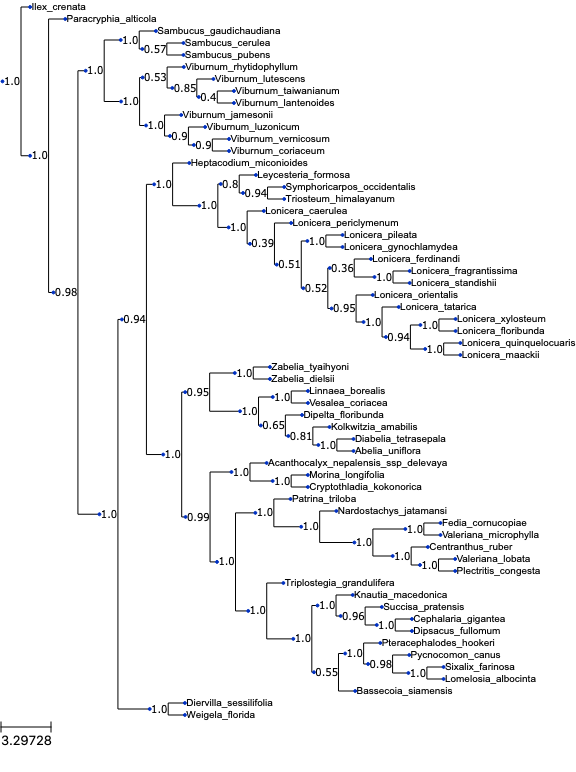

In [3]:
with open(working_dir / "Dipsacales-species-tree.BS33.rooted.tre", "r") as s:
    sptree = Tree(s.readline())
bs = TreeStyle()

def bootstrap_fn(mynode):
    if not mynode.is_leaf():
        F = TextFace(str(mynode.support))
        faces.add_face_to_node(F,mynode,0,"branch-top")
        
bs.layout_fn = bootstrap_fn
bs.mode="r"
bs.show_leaf_name = True        

sptree.render("%%inline", tree_style=bs)

### Identifying common nodes

In [4]:
phyparts_node_key = [line for line in open(keyfile)]
subtrees_dict = {n.split()[0]:Tree(n.split()[1]+";") for n in phyparts_node_key}
subtrees_topids = {}
for x in subtrees_dict:
    subtrees_topids[x] = subtrees_dict[x].get_topology_id()

for node in sptree.traverse():
    node_topid = node.get_topology_id()
    for subtree in subtrees_dict:
        if node_topid == subtrees_topids[subtree]:
            node.name = subtree

### Extracting concordance info

In [5]:
with open(conconfile) as phyparts_trees:
    concon_tree = Tree(phyparts_trees.readline())
    conflict_tree = Tree(phyparts_trees.readline())

concord_dict = {}
conflict_dict = {}

for i, node in enumerate(concon_tree.traverse()):
    node_topid = node.get_topology_id()
    for j, subtree in enumerate(subtrees_dict):
        if node_topid == subtrees_topids[subtree]:
            concord_dict[subtree] = node.support
            
for i, node in enumerate(conflict_tree.traverse()):
    node_topid = node.get_topology_id()
    for j, subtree in enumerate(subtrees_dict):
        if node_topid == subtrees_topids[subtree]:
            conflict_dict[subtree] = node.support

### Plotting node numbers

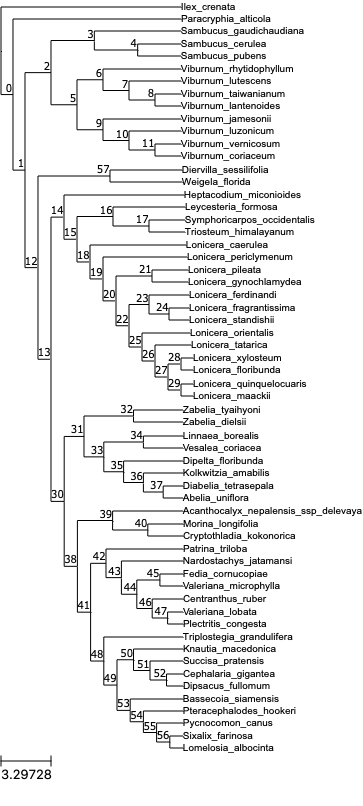

In [6]:
node_tree = sptree.copy()
node_tree.set_outgroup("Ilex_crenata")
node_tree.ladderize()

nstyle = NodeStyle()
nstyle["size"] = 0
for n in node_tree.traverse():
    n.set_style(nstyle)

node_tree.convert_to_ultrametric()  #Makes the tips sorta line up...  
ns = TreeStyle()

def node_name(node):
    if not node.is_leaf():
        F = TextFace(node.name)
        faces.add_face_to_node(face=F, node=node, column=0, position="branch-top")
        
ns.layout_fn = node_name
ns.mode="r"
ns.show_leaf_name = True        

# node_tree.render("../Figures/Concordance-analysis/Node-tree.pdf", tree_style=ns)
node_tree.render("%%inline",tree_style=ns)

### Creating pie charts

In [23]:
phyparts_hist = [line for line in open(histfile)]
phyparts_pies = {}
phyparts_dict = {}

total_genes=227
for n in phyparts_hist:
    n = n.split(",")
    tot_genes = float(n.pop(-1))
    node_name = n.pop(0)[4:]
    concord = float(n.pop(0))
    concord = concord_dict[node_name]
    all_conflict = conflict_dict[node_name]
    
    if len(n) > 0:   
        most_conflict = max([float(x) for x in n])
    else:
        most_conflict = 0.0
    
    adj_concord = (concord/total_genes) * 100 
    adj_most_conflict = (most_conflict/total_genes) * 100
    other_conflict = (all_conflict - most_conflict) / total_genes * 100
    the_rest = (total_genes - concord - all_conflict) / total_genes * 100
    
    pie_list = [adj_concord,adj_most_conflict,other_conflict,the_rest]
        
    phyparts_pies[node_name] = pie_list
    
    phyparts_dict[node_name] = [int(round(concord,0)),int(round(tot_genes-concord,0))]

### Visualizing pie charts

In [12]:
def phyparts_pie_layout(mynode):
    if mynode.name in phyparts_pies:
        pie= faces.PieChartFace(phyparts_pies[mynode.name],
                              colors = [mcolors.rgb2hex("xkcd:emerald"),
                                        mcolors.rgb2hex("xkcd:amber"),
                                        mcolors.rgb2hex("xkcd:dusty red"),
                                        mcolors.rgb2hex("xkcd:light gray")],
                              width=50, height=50)
        pie.border.width = None
        pie.opacity = 1.0
        faces.add_face_to_node(pie,mynode, 0, position="branch-right")
        
        concord_text = faces.TextFace(str(int(concord_dict[mynode.name]))+'   ',fsize=20)
        conflict_text = faces.TextFace(str(int(conflict_dict[mynode.name]))+'   ',fsize=20)
        
        faces.add_face_to_node(concord_text,mynode,0,position = "branch-top")
        faces.add_face_to_node(conflict_text,mynode,0,position="branch-bottom")
        
        
    else:
        F = faces.TextFace(mynode.name,fsize=20)
        faces.add_face_to_node(F,mynode,0,position="aligned")


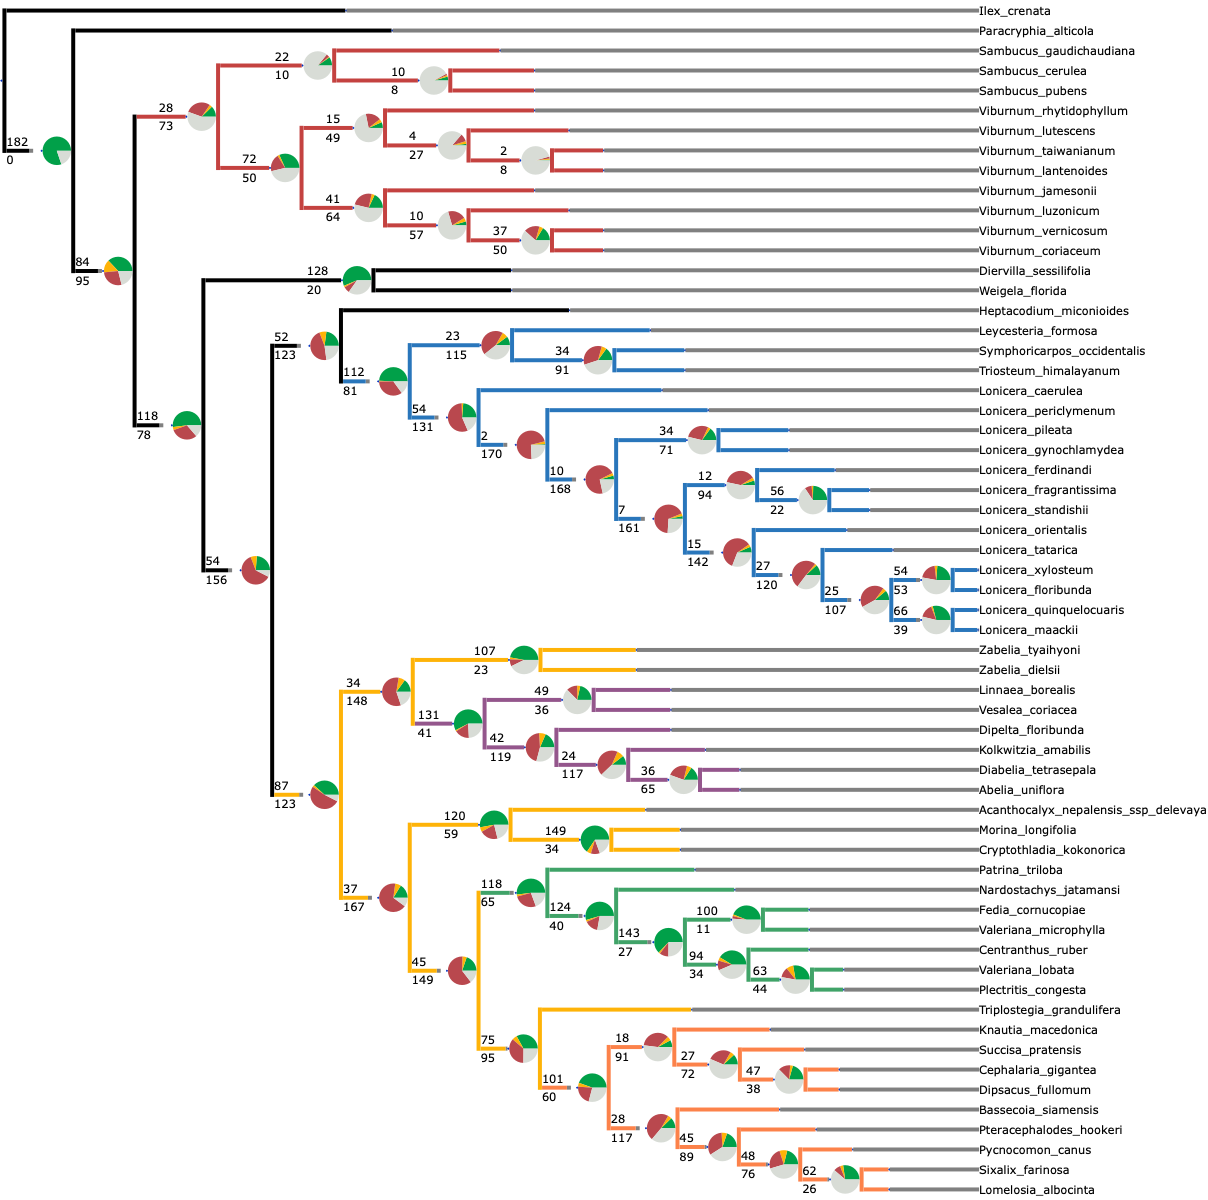

In [24]:
plot_tree = sptree.copy()
plot_tree.set_outgroup("Ilex_crenata")
plot_tree.ladderize()

ts = TreeStyle()
ts.show_leaf_name = False
        
ts.layout_fn = phyparts_pie_layout

adoxaceae_style = NodeStyle()
adoxaceae_style["vt_line_color"] = mcolors.rgb2hex("xkcd:reddish")
adoxaceae_style["hz_line_color"] = mcolors.rgb2hex("xkcd:reddish")

caprifoliaceae_style = NodeStyle()
caprifoliaceae_style["vt_line_color"] = mcolors.rgb2hex("xkcd:bluish")
caprifoliaceae_style["hz_line_color"] = mcolors.rgb2hex("xkcd:bluish")

morinaceae_style = NodeStyle()
morinaceae_style["vt_line_color"] = mcolors.rgb2hex("xkcd:amber")
morinaceae_style["hz_line_color"] = mcolors.rgb2hex("xkcd:amber")

linnaeeae_style = NodeStyle()
linnaeeae_style["vt_line_color"] = mcolors.rgb2hex("xkcd:purplish")
linnaeeae_style["hz_line_color"] = mcolors.rgb2hex("xkcd:purplish")

valerianaceae_style = NodeStyle()
valerianaceae_style["vt_line_color"] = mcolors.rgb2hex("xkcd:greenish")
valerianaceae_style["hz_line_color"] = mcolors.rgb2hex("xkcd:greenish")

dipsacaceae_style = NodeStyle()
dipsacaceae_style["vt_line_color"] = mcolors.rgb2hex("xkcd:orangish")
dipsacaceae_style["hz_line_color"] = mcolors.rgb2hex("xkcd:orangish")

for n in plot_tree.traverse():    
    if n == plot_tree.get_common_ancestor("Sambucus_pubens", "Viburnum_jamesonii"):
        for d in n.traverse(): d.set_style(adoxaceae_style)
    elif n == plot_tree.get_common_ancestor("Triosteum_himalayanum", "Lonicera_pileata"):
        for d in n.traverse(): d.set_style(caprifoliaceae_style)
    elif n == plot_tree.get_common_ancestor("Zabelia_dielsii", "Morina_longifolia"):
        for d in n.traverse(): d.set_style(morinaceae_style)
    elif n == plot_tree.get_common_ancestor("Linnaea_borealis", "Abelia_uniflora"):
        for d in n.traverse(): d.set_style(linnaeeae_style)
    elif n == plot_tree.get_common_ancestor("Patrina_triloba", "Valeriana_lobata"):
        for d in n.traverse(): d.set_style(valerianaceae_style)
    elif n == plot_tree.get_common_ancestor("Dipsacus_fullomum", "Sixalix_farinosa"):
        for d in n.traverse(): d.set_style(dipsacaceae_style)
            
    n.img_style["vt_line_width"] = 7.5
    n.img_style["hz_line_width"] = 7.5
    
ts.draw_guiding_lines = True
# ts.guiding_lines_color = "black"
ts.guiding_lines_type = 0
ts.scale = 50
ts.branch_vertical_margin = 10
ts.show_scale = False
plot_tree.convert_to_ultrametric()    
# plot_tree.render("../Figures/FINAL_PIE_CHARTS.left-tree.png", tree_style=ts, units="px", h=3600, w=3600, dpi=96, ) 
plot_tree.render("%%inline", tree_style=ts, units="in", h=12.5, dpi=96)

In [342]:
adox_nodes = np.arange(2,12)
non_adox_info = []
adox_info = []
for k, v in phyparts_pies.items():
    if int(k) in adox_nodes:
        adox_info.append(sum(v[:-1]))
    else:
        non_adox_info.append(sum(v[:-1]))
print("Adoxaceae: {} +/- {}".format(np.mean(adox_info)*227/100, np.std(adox_info)*227/100))
print("Other: {} +/- {}".format(np.mean(non_adox_info)*227/100, np.std(non_adox_info)*227/100))

Adoxaceae: 63.70000000000001 +/- 37.54477327138892
Other: 148.04166666666663 +/- 36.89735668791947


In [343]:
caprifolioideae_nodes = np.arange(18,30)
caprifolioideae_info = []
for k, v in phyparts_pies.items():
    if int(k) in caprifolioideae_nodes:
        caprifolioideae_info.append(sum(v[:-1]))

print("caprifolioideaeaceae: {} +/- {}".format(np.mean(caprifolioideae_info)*227/100, np.std(caprifolioideae_info)*227/100))

caprifolioideaeaceae: 136.66666666666666 +/- 34.259629627627646


In [6]:
dips = toytree.tree(str(working_dir / "Dipsacales-species-tree.BS33.rooted.tre"))

In [5]:
canvas = toyplot.Canvas(width=3600, height=3600, style={"background-color":"white"})

axes = canvas.cartesian(bounds=(1000, 3500, 0, 3600))
axes.show = False

cmap = plt.cm.RdYlGn
node_colors = []
node_sizes = []
for s in dips.get_node_values('support', show_root=0, show_tips=0):
    try:
        node_colors.append(mcolors.to_hex(cmap(float(s))))
        node_sizes.append(50)
    except ValueError:
        node_colors.append("white")
        node_sizes.append(0)


ecolors = dips.get_edge_values_from_dict({
    ("Sambucus_pubens", "Viburnum_jamesonii"): mcolors.rgb2hex("xkcd:reddish"),
    ("Triosteum_himalayanum", "Lonicera_pileata"):mcolors.rgb2hex("xkcd:bluish"),
    ("Zabelia_dielsii", "Morina_longifolia"):mcolors.rgb2hex("xkcd:amber"),
    ("Linnaea_borealis", "Abelia_uniflora"):mcolors.rgb2hex("xkcd:purplish"),
    ("Patrina_triloba", "Valeriana_lobata"):mcolors.rgb2hex("xkcd:greenish"),
    ("Dipsacus_fullomum", "Sixalix_farinosa"):mcolors.rgb2hex("xkcd:orangish")})
        
fillwidth = max([len(t) for t in dips.get_tip_labels()])
tip_labels = [label if "Patrina" not in label else label.replace("Patrina", "Patrinia") for label in dips.get_tip_labels()]
tip_labels = [re.sub("_", " ", tip).ljust(fillwidth) for tip in tip_labels]
dips.ladderize().draw(axes=axes, tip_labels=tip_labels, tip_labels_align=True, edge_colors=ecolors,
                      tip_labels_style={"font-size":"40px"},
                      node_labels=None, node_sizes=node_sizes, node_colors=node_colors, 
                      use_edge_lengths=False, edge_widths=10, node_style={"stroke":"black"}, 
                      scalebar=False, layout="left");

<svg class="toyplot-canvas-Canvas" height="3600.0px" id="td60ddfe35a00453b86916b613a46ec86" preserveAspectRatio="xMidYMid meet" style="background-color:white;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 3600.0 3600.0" width="3600.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Lomelosia albocinta Sixalix farinosa Pycnocomon canus Pteracephalodes hookeri Bassecoia siamensis Dipsacus fullomum Cephalaria gigantea Succisa pratensis Knautia macedonica Triplostegia grandulifera Plectritis congesta Valeriana lobata Centranthus ruber Valeriana microphylla Fedia cornucopiae Nardostachys jatamansi Patrinia triloba Cryptothladia kokonorica Morina longifolia Acanthocalyx nepalensis ssp delevaya Abelia uniflora Diabelia tetrasepala Kolkwitzia amabilis Dipelta floribunda Vesalea coriacea Linnaea borealis Zabelia dielsii Zabelia tyaihyoni Lonicera maackii Lonicera quinquelocuaris Lonicera floribunda Lonicera xylosteum Lonicera tatarica Lonicera orientalis Lonicera standishii Lonicera fragrantissima Lonicera ferdinandi Lonicera gynochlamydea Lonicera pileata Lonicera periclymenum Lonicera caerulea Triosteum himalayanum Symphoricarpos occidentalis Leycesteria formosa Heptacodium miconioides Weigela florida Diervilla sessilifolia Viburnum coriaceum Viburnum vernicosum Viburnum luzonicum Viburnum jamesonii Viburnum lantenoides Viburnum taiwanianum Viburnum lutescens Viburnum rhytidophyllum Sambucus pubens Sambucus cerulea Sambucus gaudichaudiana Paracryphia alticola Ilex crenata

In [104]:
toyplot.png.render(canvas, "../Figures/FINAL_SPECIES_TREE.right-tree.png", height="3600px")

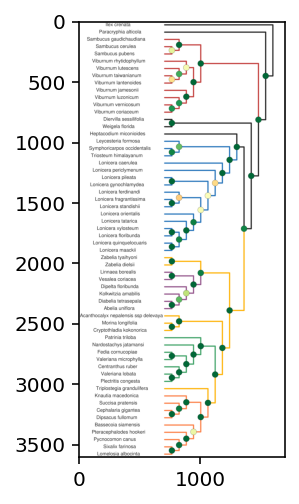

In [7]:
righttree = plt.imread("../Figures/Concordance-analysis/FINAL_SPECIES_TREE.right-tree.png")
plt.imshow(righttree[:, 1900:3600]);

/Users/iangilman/miniconda3/envs/phylo/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


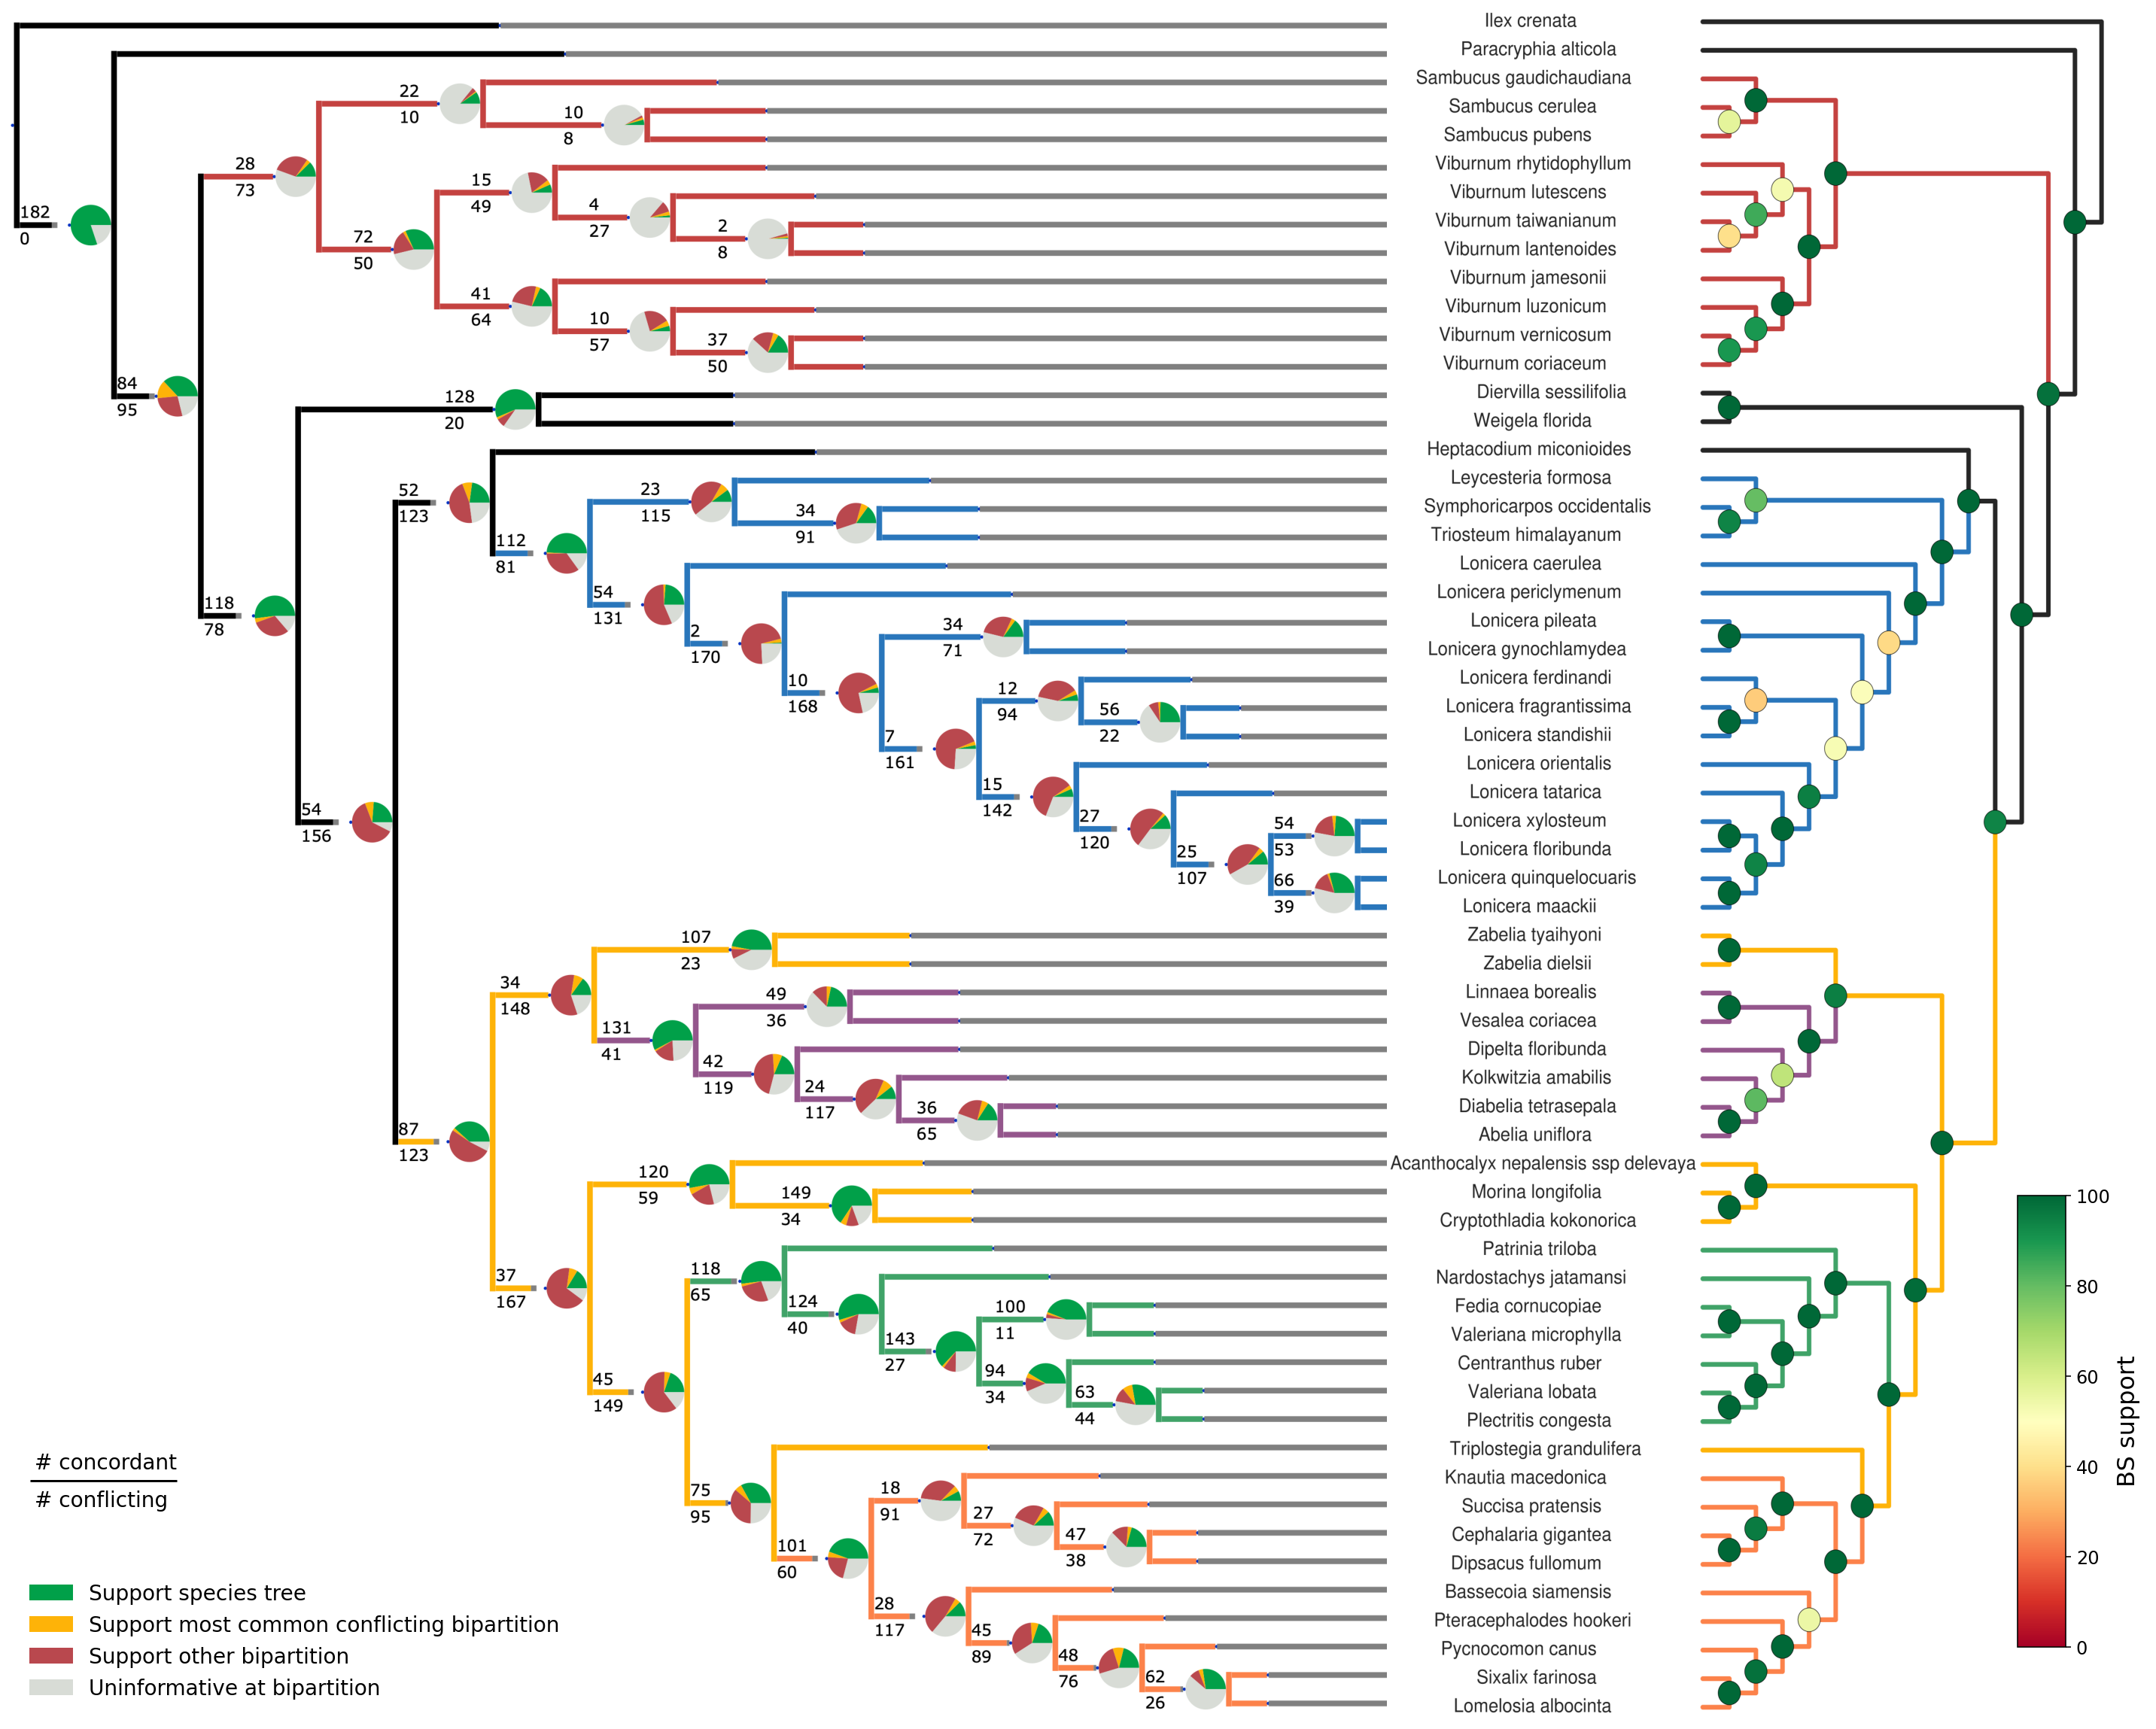

In [112]:
fig, ax = plt.subplots(figsize = (20, 20))

leftree = plt.imread("../Figures/FINAL_PIE_CHARTS.left-tree.png")[:, :]
righttree = plt.imread("../Figures/FINAL_SPECIES_TREE.right-tree.png")[:, 1900:3600]

ax.imshow(leftree, extent=(0, 3600, 0, 3600))
ax.imshow(righttree, extent=(2900, 4500, 0, 3600))

ax.set_xlim(0, 4500)
ax.set_ylim(0, 3600)

ax.hlines(y=500, xmin=40, xmax=350, colors="black")
ax.text(x = 50, y = 525, s= "# concordant", size=14)
ax.text(x = 50, y = 445, s= "# conflicting", size=14)

greenpatch = mpatches.Patch(color="xkcd:emerald", label='Support species tree')
yellowpatch = mpatches.Patch(color="xkcd:amber", label='Support most common conflicting bipartition')
redpatch = mpatches.Patch(color="xkcd:dusty red", label='Support other bipartition')
greypatch = mpatches.Patch(color="xkcd:light grey", label='Uninformative at bipartition') 

ax.legend(handles=[greenpatch, yellowpatch, redpatch, greypatch], fontsize=14, loc='lower left', frameon=False)

cmap = plt.cm.RdYlGn
norm = mcolors.Normalize(vmin=0, vmax=100)
cax = fig.add_axes([4200/4500, 500/3600, 100/4500, 750/3600]) # [x0, y0, width, height]
cbar = colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
cbar.ax.tick_params(labelsize=12)
cbar.set_label("BS support", size=16)

ax.axis("off")

plt.tight_layout()
# plt.savefig("../Figures/Dipsacales-concordance-BS-tree.pdf", dpi=300, transparent=True)

### _Heptacodium_ alternate placement

In [7]:
caprifolieae_node = dips.get_mrca_idx_from_tip_labels(["Leycesteria_formosa", "Lonicera_maackii"])
caprifolieae_taxa = dips.get_tip_labels(idx=caprifolieae_node)
linnaeeae_node = dips.get_mrca_idx_from_tip_labels(["Linnaea_borealis", "Abelia_uniflora"])
linnaeeae_taxa = dips.get_tip_labels(idx=linnaeeae_node)
linnina_node = dips.get_mrca_idx_from_tip_labels(["Zabelia_dielsii", "Sixalix_farinosa"])
linnina_taxa = dips.get_tip_labels(idx=linnina_node)
morinaceae_node = dips.get_mrca_idx_from_tip_labels(["Morina_longifolia", "Acanthocalyx_nepalensis_ssp_delevaya"])
morinaceae_taxa = dips.get_tip_labels(idx=morinaceae_node)
zabelia_taxa = ["Zabelia_tyaihyoni", "Zabelia_dielsii"]
valerianaceae_node = dips.get_mrca_idx_from_tip_labels(["Patrina_triloba", "Valeriana_lobata"])
valerianaceae_taxa = dips.get_tip_labels(idx=valerianaceae_node)
dipsacoideae_node = dips.get_mrca_idx_from_tip_labels(["Triplostegia_grandulifera", "Sixalix_farinosa"])
dipsacoideae_taxa = dips.get_tip_labels(idx=dipsacoideae_node)

Now what I'll do is extract all of the gene trees that have 
1. _Heptacodium_
2. At least one member of Caprifolieae
3. At least one member of Linnina

In [15]:
genetreespath = working_dir / "Dipsacales-gene-trees.BS33.rooted.trees"

hept_testable = []
with open(genetreespath, "r") as f:
    for line in f.readlines():
        if ("Heptacodium_miconioides" in line) and \
            any([cap in line for cap in caprifolieae_taxa]) and \
            any([lin in line for lin in linnina_taxa]):
            hept_testable.append(line)

In [16]:
# Unambiguously support
hept_cap = 0
hept_lin = 0
# Sister to a majority of one clade
favor_cap = 0
favor_lin = 0
# Completely ambiguous
hept_ambig = 0

for gt in [toytree.tree(newick) for newick in hept_testable]:
    hept_idx = gt.get_mrca_idx_from_tip_labels("Heptacodium_miconioides")
    hept_node = [node for node in gt.treenode.traverse("levelorder") if node.idx==hept_idx][0]
    sister_taxa = hept_node.get_sisters()[0].get_leaf_names()
    sister_caps = list(set(caprifolieae_taxa).intersection(set(sister_taxa)))
#     sister_lins = list(set(linnaeeae_taxa).intersection(set(sister_taxa)))
    sister_lins = list(set(linnina_taxa).intersection(set(sister_taxa)))
    
    if len(sister_caps) > len(sister_lins): # Hept has more Cap sister taxa than Lin taxa
        favor_cap+=1
        if len(sister_lins)==0: # Hept has no sister Lin taxa
            hept_cap+=1
    elif len(sister_lins) > len(sister_caps): # Hept has more Lin sister taxa than Cap taxa
        favor_lin+=1
        if len(sister_caps)==0: # Hept has no Cap taxa
            hept_lin+=1
    else:
        hept_ambig+=1

print("{} gene trees".format(len(hept_testable)))
print("Favor Hept+Cap: {} ({:.2})\n\tUnambiguously: {} ({:.2})".format(favor_cap,favor_cap/len(hept_testable), hept_cap, hept_cap/len(hept_testable)))
print("Favor Hept+Lin: {} ({:.2})\n\tUnambiguously: {} ({:.2})".format(favor_lin, favor_lin/len(hept_testable), hept_lin, hept_lin/len(hept_testable)))
print("Ambiguous: {} ({:.2})".format(hept_ambig, hept_ambig/len(hept_testable)))

146 gene trees
Favor Hept+Cap: 78 (0.53)
	Unambiguously: 75 (0.51)
Favor Hept+Lin: 49 (0.34)
	Unambiguously: 32 (0.22)
Ambiguous: 19 (0.13)


So, despite the large red slice of the pie chart at the node that includes *Heptacodium*, Caprifolieae, and Linnaeeae, most gene trees support the relationship (*Heptacodium*, Caprifolieae). No we can repeat this with *Zabelia*.

### *Zabelia* position
It remains unclear whether *Zabelia* is more closely related to the Linnaeeae or Morinaceae. Some studies have found is sister to the Dipsacoideae, but this is less common.

Also try against Linina and Dips+Val

In [204]:
zab_testable = []
with open(genetreespath, "r") as f:
    for line in f.readlines():
        if any([zab in line for zab in zabelia_taxa]) and \
            any([mor in line for mor in morinaceae_taxa]) and \
            any([dip in line for dip in dipsacoideae_taxa]) and \
            any([val in line for val in valerianaceae_taxa]) and \
            any([lin in line for lin in linnaeeae_taxa]):
            zab_testable.append(line)
print(len(zab_testable))

176


In [205]:
# Unambiguously support
zab_mor = 0
zab_dip = 0
zab_lin = 0
zab_val = 0
# Sister to a majority of one clade
favor_mor = 0
favor_dip = 0
favor_lin = 0
favor_val = 0
# Ambiguous
zab_ambig = 0

for gt in [toytree.tree(newick) for newick in zab_testable]:
    try:
        zab_idx = gt.get_mrca_idx_from_tip_labels(zabelia_taxa)
    except:
        zab_idx = gt.get_mrca_idx_from_tip_labels([s for s in gt.get_tip_labels() if "Zabelia" in s].pop())
    zab_node = [node for node in gt.treenode.traverse("levelorder") if node.idx==zab_idx][0]
    sister_taxa = zab_node.get_sisters()[0].get_leaf_names()
    sister_mors = list(set(morinaceae_taxa).intersection(set(sister_taxa)))
    sister_dips = list(set(dipsacoideae_taxa).intersection(set(sister_taxa)))
    sister_lins = list(set(linnaeeae_taxa).intersection(set(sister_taxa)))
    sister_vals = list(set(valerianaceae_taxa).intersection(set(sister_taxa)))

    if len(sister_mors) >  max(len(sister_dips), len(sister_lins), len(sister_vals)):
        favor_mor+=1
        if len(sister_lins)==len(sister_dips)==len(sister_vals)==0:
            zab_mor+=1
        else:
            zab_ambig+=1
    elif len(sister_lins) > max(len(sister_dips), len(sister_mors), len(sister_vals)):
        favor_lin+=1
        if len(sister_mors)==len(sister_dips)==len(sister_vals)==0:
            zab_lin+=1
        else:
            zab_ambig+=1
    elif len(sister_dips) > max(len(sister_lins), len(sister_mors), len(sister_vals)):
        favor_dip+=1
        if len(sister_mors)==len(sister_lins)==len(sister_vals)==0:
            zab_dip+=1
        else:
            zab_ambig+=1
    elif len(sister_vals) > max(len(sister_lins), len(sister_mors), len(sister_dips)):
        favor_val+=1
        if len(sister_vals) > len(sister_mors)==len(sister_lins)==len(sister_dips)==0:
            zab_val+=1
        else:
            zab_ambig+=1
    else:
        zab_ambig+=1
print("{} gene trees".format(len(zab_testable)))
print("Favor Zab+Mor: {} ({:.2})\n\tUnambiguously: {} ({:.2})".format(favor_mor, favor_mor/len(zab_testable), zab_mor, zab_mor/len(zab_testable)))
print("Favor Zab+Lin: {} ({:.2})\n\tUnambiguously: {} ({:.2})".format(favor_lin, favor_lin/len(zab_testable), zab_lin, zab_lin/len(zab_testable)))
print("Favor Zab+Dip: {} ({:.2})\n\tUnambiguously: {} ({:.2})".format(favor_dip, favor_dip/len(zab_testable), zab_dip, zab_dip/len(zab_testable)))
print("Favor Zab+Val: {} ({:.2})\n\tUnambiguously: {} ({:.2})".format(favor_val, favor_val/len(zab_testable), zab_val, zab_val/len(zab_testable)))
print("Ambiguous: {} ({:.2})".format(zab_ambig, zab_ambig/len(zab_testable)))

176 gene trees
Favor Zab+Mor: 37 (0.21)
	Unambiguously: 35 (0.2)
Favor Zab+Lin: 51 (0.29)
	Unambiguously: 48 (0.27)
Favor Zab+Dip: 47 (0.27)
	Unambiguously: 12 (0.068)
Favor Zab+Val: 15 (0.085)
	Unambiguously: 6 (0.034)
Ambiguous: 75 (0.43)


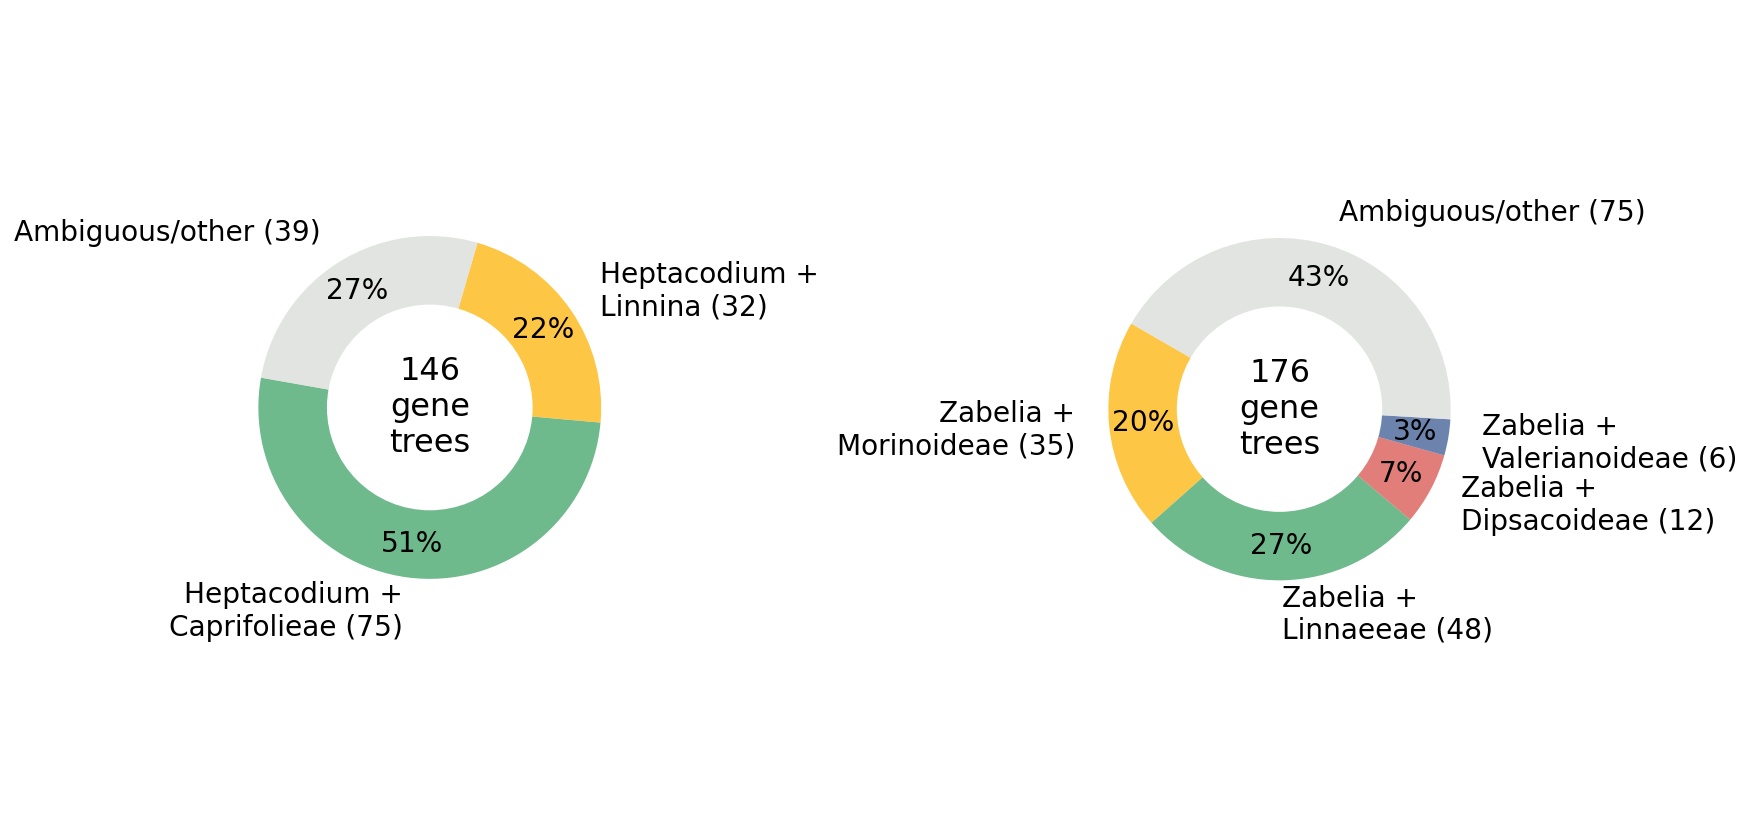

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# First pie
labels=["Heptacodium +\nCaprifolieae ({})".format(hept_cap),
        "Heptacodium +\nLinnina ({})".format(hept_lin),
        "Ambiguous/other ({})".format(146-hept_cap-hept_lin)]
sizes = [hept_cap, hept_lin, len(hept_testable)-hept_cap-hept_lin]

colors = ["xkcd:greenish","xkcd:amber", "xkcd:light grey"]

patches, texts, autotexts = ax[0].pie(sizes, startangle=170, labels=labels, colors=colors, 
                                      autopct='%1.f%%', pctdistance=0.8, labeldistance=1.2)

# Edit patches and text
for p in patches:
    p.set_alpha(0.75)
for i, t in enumerate(autotexts):
    t.set_size(14)
    texts[i].set_size(14)
# Add center cirle with text
centre_circle0 = plt.Circle((0,0), 0.6, color='black', fc='white',linewidth=0)
ax[0].add_artist(centre_circle0)
ax[0].text(x=0, y=0, s="{}\ngene\ntrees".format(len(hept_testable)), 
           horizontalalignment='center', verticalalignment='center', size=16)
ax[0].axis('equal')

# Second pie
labels=["Zabelia +\nMorinoideae ({})".format(zab_mor),
        "Zabelia +\nLinnaeeae ({})".format(zab_lin),
        "Zabelia +\nDipsacoideae ({})".format(zab_dip),
        "Zabelia +\nValerianoideae ({})".format(zab_val),
        "Ambiguous/other ({})".format(len(zab_testable)-zab_dip-zab_lin-zab_mor-zab_val)]
sizes = [zab_mor, zab_lin, zab_dip, zab_val, len(zab_testable)-zab_dip-zab_lin-zab_mor-zab_val]

colors = ["xkcd:amber", "xkcd:greenish", "xkcd:pale red", "xkcd:denim blue", "xkcd:light grey"]

patches, texts, autotexts = ax[1].pie(sizes, startangle=150, labels=labels, colors=colors, 
                                      autopct='%1.f%%', pctdistance=0.8, labeldistance=1.2)

# Edit patches and text
for p in patches:
    p.set_alpha(0.75)
for i, t in enumerate(autotexts):
    t.set_size(14)
    texts[i].set_size(14)
# Add center cirle with text
centre_circle1 = plt.Circle((0,0), 0.6, color='black', fc='white',linewidth=0)
ax[1].add_artist(centre_circle1)
ax[1].text(x=0, y=0, s="{}\ngene\ntrees".format(len(zab_testable)), 
           horizontalalignment='center', verticalalignment='center', size=16)
ax[1].axis('equal')

plt.tight_layout()
plt.savefig("../Figures/Concordance-analysis/Hept-Zab_concordance-pies.pdf", dpi=300, bbox_inches="tight")

## Position of *Abelia* within Linnaeeae
Specifically I'll investigate the position of *Abelia*, *Diabelia*, *Kolkwitzia*, and *Dipelta*. Chloroplast data tend to show 
- (((*Dipelta*, *Diabelia*), *Kolkwitza*), *Abelia*) (Wang et al., 2020) or
- (((*Diabelia*, *Kolkwitzia*), *Dipelta*), *Abelia*) (Xiang et al., 2020)

In [229]:
nuc_topo = toytree.tree(newick="((((Abelia_uniflora, Diabelia_tetrasepala), Kolkwitzia_amabilis), Dipelta_floribunda), (Linnaea_borealis,Vesalea_coriacea));")
wang_topo = toytree.tree(newick="((((Dipelta_floribunda, Diabelia_tetrasepala), Kolkwitzia_amabilis), Abelia_uniflora), (Linnaea_borealis,Vesalea_coriacea));")
xiang_topo = toytree.tree(newick="((((Kolkwitzia_amabilis, Diabelia_tetrasepala), Dipelta_floribunda), Abelia_uniflora), (Linnaea_borealis,Vesalea_coriacea));")

canvas = toyplot.Canvas(width=1000, height=350)
ax0 = canvas.cartesian(grid=(1, 3, 0), yshow=False, xshow=False)
ax1 = canvas.cartesian(grid=(1, 3, 1), yshow=False, xshow=False)
ax2 = canvas.cartesian(grid=(1, 3, 2), yshow=False, xshow=False)

ax0.text(a=0, b=6, text="<b>Nuclear (ASTRAL)</b>", color="black", style={"font-family": "helvetica"})
ax1.text(a=0, b=6, text="<b>Chloroplast (Wang et al., 2020)</b>", color="black")
ax2.text(a=0, b=6, text="<b>Chloroplast (Xiang et al., 2020)</b>", color="black")

nuc_topo.draw(edge_widths=2, axes=ax0, node_labels_style={"font-family": "helvetica"})
wang_topo.draw(edge_widths=2, axes=ax1, node_labels_style={"font-family": "helvetica"})
xiang_topo.draw(edge_widths=2, axes=ax2, node_labels_style={"font-family": "helvetica"});

<svg class="toyplot-canvas-Canvas" height="350.0px" id="teec3b663a4824f90b3c67ba0f92589f0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 1000.0 350.0" width="1000.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Nuclear (ASTRAL) Diabelia_tetrasepala Abelia_uniflora Kolkwitzia_amabilis Dipelta_floribunda Vesalea_coriacea Linnaea_borealis Chloroplast (Wang et al., 2020) Diabelia_tetrasepala Dipelta_floribunda Kolkwitzia_amabilis Abelia_uniflora Vesalea_coriacea Linnaea_borealis Chloroplast (Xiang et al., 2020) Diabelia_tetrasepala Kolkwitzia_amabilis Dipelta_floribunda Abelia_uniflora Vesalea_coriacea Linnaea_borealis

In [230]:
def get_leaf_sets(tree):
    return [set(node.get_leaf_names()) for node in tree.treenode.traverse("levelorder")]

In [231]:
nuc_leaf_sets = get_leaf_sets(nuc_topo)
wang_leaf_sets = get_leaf_sets(wang_topo)
xiang_leaf_sets = get_leaf_sets(xiang_topo)

In [232]:
ab_testable = []
with open(genetreespath, "r") as f:
    for line in f.readlines():
        if (all([ab in line for ab in linnaeeae_taxa])):
            ab_testable.append(line)
print(len(ab_testable))

69


In [235]:
ab_diab_sister = 0
support_nuc = 0
support_ab_diab_other = 0
support_other = 0
support_wang = 0
support_xiang = 0

for gt in [toytree.tree(newick) for newick in ab_testable]:
    gt = gt.root(names="Ilex_crenata")
    lin_idx = gt.get_mrca_idx_from_tip_labels(linnaeeae_taxa)
    lin_subtree = toytree.tree([node for node in gt.treenode.traverse("levelorder") if node.idx==lin_idx][0])
    lin_leaf_sets = get_leaf_sets(lin_subtree)
    if {'Abelia_uniflora', 'Diabelia_tetrasepala'} in lin_leaf_sets:
        ab_diab_sister+=1
        gt.draw()
        if all([ls in lin_leaf_sets for ls in nuc_leaf_sets]):
            support_nuc+=1
        else:
            support_ab_diab_other+=1
    elif all([ls in lin_leaf_sets for ls in wang_leaf_sets]): 
        support_wang+=1
    elif all([ls in lin_leaf_sets for ls in xiang_leaf_sets]): 
        support_xiang+=1
    else:
        support_other+=1

print("{} gene trees support (Abelia, Diabelia)".format(ab_diab_sister))
print("\t{} gene trees support the nuclear topology".format(support_nuc))
print("\t{} gene trees support (Abelia, Diabelia) but not the nuclear topology".format(support_ab_diab_other))
print("{} gene trees support the Wang et al. (2020) topology".format(support_wang))
print("{} gene trees support the Xiang et al. (2020) topology".format(support_xiang))
print("{} gene trees support another topology".format(support_other))

26 gene trees support (Abelia, Diabelia)
	0 gene trees support the nuclear topology
	26 gene trees support (Abelia, Diabelia) but not the nuclear topology
0 gene trees support the Wang et al. (2020) topology
0 gene trees support the Xiang et al. (2020) topology
43 gene trees support another topology


<svg class="toyplot-canvas-Canvas" height="1000.0px" id="t3b8e80e73b9747fe901776b2a199b387" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 1000.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Pycnocomon_canus Pteracephalodes_hookeri Lomelosia_albocinta Sixalix_farinosa Cryptothladia_kokonorica Knautia_macedonica Dipsacus_fullomum Cephalaria_gigantea Succisa_pratensis Bassecoia_siamensis Triplostegia_grandulifera Acanthocalyx_nepalensis_ssp_delevaya Morina_longifolia Plectritis_congesta Centranthus_ruber Valeriana_lobata Valeriana_microphylla Fedia_cornucopiae Nardostachys_jatamansi Patrina_triloba Vesalea_coriacea Linnaea_borealis Dipelta_floribunda Kolkwitzia_amabilis Abelia_uniflora Diabelia_tetrasepala Zabelia_dielsii Zabelia_tyaihyoni Lonicera_tatarica Triosteum_himalayanum Lonicera_caerulea Lonicera_xylosteum Lonicera_ferdinandi Lonicera_periclymenum Lonicera_maackii Lonicera_quinquelocuaris Lonicera_pileata Lonicera_standishii Lonicera_fragrantissima Lonicera_orientalis Symphoricarpos_occidentalis Leycesteria_formosa Lonicera_floribunda Lonicera_gynochlamydea Heptacodium_miconioides Diervilla_sessilifolia Weigela_florida Viburnum_coriaceum Viburnum_vernicosum Viburnum_lutescens Viburnum_jamesonii Viburnum_luzonicum Viburnum_rhytidophyllum Sambucus_gaudichaudiana Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="1000.0px" id="tf54594cac98f4127a5e3d5cf7318b37b" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 1000.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Abelia_uniflora Diabelia_tetrasepala Kolkwitzia_amabilis Linnaea_borealis Vesalea_coriacea Dipelta_floribunda Zabelia_dielsii Zabelia_tyaihyoni Acanthocalyx_nepalensis_ssp_delevaya Cryptothladia_kokonorica Morina_longifolia Lomelosia_albocinta Sixalix_farinosa Pycnocomon_canus Succisa_pratensis Cephalaria_gigantea Knautia_macedonica Dipsacus_fullomum Bassecoia_siamensis Pteracephalodes_hookeri Triplostegia_grandulifera Plectritis_congesta Valeriana_lobata Centranthus_ruber Fedia_cornucopiae Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Lonicera_quinquelocuaris Lonicera_maackii Lonicera_floribunda Lonicera_xylosteum Lonicera_tatarica Lonicera_periclymenum Lonicera_fragrantissima Lonicera_standishii Lonicera_ferdinandi Lonicera_gynochlamydea Lonicera_pileata Lonicera_orientalis Lonicera_caerulea Symphoricarpos_occidentalis Leycesteria_formosa Triosteum_himalayanum Heptacodium_miconioides Weigela_florida Diervilla_sessilifolia Viburnum_lantenoides Viburnum_rhytidophyllum Viburnum_lutescens Viburnum_vernicosum Viburnum_taiwanianum Viburnum_luzonicum Viburnum_jamesonii Viburnum_coriaceum Paracryphia_alticola Sambucus_cerulea Sambucus_gaudichaudiana Sambucus_pubens Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="792.0px" id="t8b48454d2b0a47e5878f5bddded3edb3" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 792.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Sixalix_farinosa Lomelosia_albocinta Lonicera_xylosteum Lonicera_periclymenum Lonicera_maackii Diervilla_sessilifolia Heptacodium_miconioides Lonicera_standishii Lonicera_fragrantissima Lonicera_orientalis Lonicera_ferdinandi Lonicera_gynochlamydea Lonicera_pileata Lonicera_tatarica Lonicera_floribunda Lonicera_quinquelocuaris Leycesteria_formosa Triosteum_himalayanum Lonicera_caerulea Diabelia_tetrasepala Abelia_uniflora Kolkwitzia_amabilis Dipelta_floribunda Vesalea_coriacea Zabelia_dielsii Linnaea_borealis Triplostegia_grandulifera Patrina_triloba Valeriana_microphylla Centranthus_ruber Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Viburnum_taiwanianum Viburnum_luzonicum Symphoricarpos_occidentalis Sambucus_cerulea Viburnum_coriaceum Viburnum_vernicosum Viburnum_rhytidophyllum Viburnum_jamesonii Sambucus_gaudichaudiana Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="936.0px" id="t32f421f09fd4436c8b5cf85c61139ad8" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 936.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Centranthus_ruber Valeriana_lobata Plectritis_congesta Fedia_cornucopiae Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Sixalix_farinosa Pycnocomon_canus Succisa_pratensis Bassecoia_siamensis Cephalaria_gigantea Triplostegia_grandulifera Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Abelia_uniflora Diabelia_tetrasepala Kolkwitzia_amabilis Dipelta_floribunda Vesalea_coriacea Linnaea_borealis Zabelia_tyaihyoni Zabelia_dielsii Heptacodium_miconioides Lonicera_quinquelocuaris Lonicera_tatarica Lonicera_floribunda Lonicera_xylosteum Lonicera_gynochlamydea Lonicera_orientalis Lonicera_fragrantissima Lonicera_standishii Lonicera_pileata Lonicera_maackii Lonicera_caerulea Lonicera_periclymenum Lonicera_ferdinandi Symphoricarpos_occidentalis Leycesteria_formosa Triosteum_himalayanum Diervilla_sessilifolia Weigela_florida Viburnum_jamesonii Sambucus_cerulea Viburnum_taiwanianum Viburnum_luzonicum Viburnum_vernicosum Viburnum_coriaceum Paracryphia_alticola Viburnum_lutescens Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="918.0px" id="t435526057c944756b49848001f9b85be" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 918.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Sixalix_farinosa Pycnocomon_canus Pteracephalodes_hookeri Bassecoia_siamensis Cephalaria_gigantea Nardostachys_jatamansi Valeriana_lobata Plectritis_congesta Valeriana_microphylla Triplostegia_grandulifera Abelia_uniflora Diabelia_tetrasepala Kolkwitzia_amabilis Dipelta_floribunda Linnaea_borealis Vesalea_coriacea Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Zabelia_dielsii Zabelia_tyaihyoni Heptacodium_miconioides Lonicera_floribunda Lonicera_xylosteum Lonicera_ferdinandi Lonicera_caerulea Lonicera_gynochlamydea Lonicera_pileata Lonicera_maackii Lonicera_quinquelocuaris Lonicera_standishii Lonicera_fragrantissima Lonicera_tatarica Lonicera_periclymenum Lonicera_orientalis Symphoricarpos_occidentalis Leycesteria_formosa Triosteum_himalayanum Weigela_florida Diervilla_sessilifolia Viburnum_luzonicum Viburnum_coriaceum Viburnum_taiwanianum Viburnum_vernicosum Viburnum_lutescens Viburnum_jamesonii Viburnum_rhytidophyllum Sambucus_cerulea Sambucus_gaudichaudiana Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="1000.0px" id="tdca910da43ef4bc2a8ae605e9ad32da6" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 1000.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Lonicera_tatarica Lonicera_xylosteum Lonicera_orientalis Lonicera_pileata Lonicera_gynochlamydea Lonicera_ferdinandi Lonicera_periclymenum Leycesteria_formosa Triosteum_himalayanum Lonicera_standishii Lonicera_fragrantissima Lonicera_caerulea Lonicera_quinquelocuaris Symphoricarpos_occidentalis Lonicera_maackii Lonicera_floribunda Weigela_florida Diervilla_sessilifolia Heptacodium_miconioides Viburnum_jamesonii Viburnum_lutescens Viburnum_coriaceum Viburnum_luzonicum Viburnum_vernicosum Viburnum_rhytidophyllum Sambucus_gaudichaudiana Sambucus_cerulea Paracryphia_alticola Linnaea_borealis Vesalea_coriacea Kolkwitzia_amabilis Dipelta_floribunda Abelia_uniflora Diabelia_tetrasepala Zabelia_tyaihyoni Zabelia_dielsii Cephalaria_gigantea Dipsacus_fullomum Succisa_pratensis Bassecoia_siamensis Pteracephalodes_hookeri Pycnocomon_canus Sixalix_farinosa Lomelosia_albocinta Cryptothladia_kokonorica Knautia_macedonica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Triplostegia_grandulifera Plectritis_congesta Valeriana_lobata Centranthus_ruber Fedia_cornucopiae Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="684.0px" id="t1d024c2caf934d768322109b76716b0d" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 684.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Diabelia_tetrasepala Abelia_uniflora Vesalea_coriacea Linnaea_borealis Kolkwitzia_amabilis Dipelta_floribunda Zabelia_tyaihyoni Zabelia_dielsii Acanthocalyx_nepalensis_ssp_delevaya Triplostegia_grandulifera Knautia_macedonica Patrina_triloba Nardostachys_jatamansi Diervilla_sessilifolia Lonicera_pileata Lonicera_gynochlamydea Lonicera_fragrantissima Symphoricarpos_occidentalis Lonicera_caerulea Leycesteria_formosa Triosteum_himalayanum Lonicera_xylosteum Lonicera_floribunda Lonicera_maackii Lonicera_quinquelocuaris Lonicera_orientalis Lonicera_tatarica Lonicera_standishii Viburnum_jamesonii Viburnum_rhytidophyllum Viburnum_lutescens Morina_longifolia Cryptothladia_kokonorica Pycnocomon_canus Weigela_florida Viburnum_vernicosum Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="1000.0px" id="t5e4f637b26c541a2815d045a9f3a1f4f" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 1000.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Succisa_pratensis Dipsacus_fullomum Cephalaria_gigantea Knautia_macedonica Pycnocomon_canus Lomelosia_albocinta Sixalix_farinosa Pteracephalodes_hookeri Bassecoia_siamensis Triplostegia_grandulifera Plectritis_congesta Valeriana_lobata Centranthus_ruber Fedia_cornucopiae Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Diabelia_tetrasepala Abelia_uniflora Dipelta_floribunda Linnaea_borealis Vesalea_coriacea Kolkwitzia_amabilis Morina_longifolia Cryptothladia_kokonorica Acanthocalyx_nepalensis_ssp_delevaya Zabelia_dielsii Zabelia_tyaihyoni Lonicera_quinquelocuaris Lonicera_maackii Lonicera_floribunda Lonicera_xylosteum Lonicera_tatarica Lonicera_standishii Lonicera_fragrantissima Lonicera_ferdinandi Lonicera_pileata Lonicera_gynochlamydea Lonicera_caerulea Lonicera_orientalis Lonicera_periclymenum Triosteum_himalayanum Leycesteria_formosa Symphoricarpos_occidentalis Heptacodium_miconioides Diervilla_sessilifolia Weigela_florida Viburnum_taiwanianum Viburnum_lantenoides Viburnum_rhytidophyllum Viburnum_lutescens Viburnum_coriaceum Viburnum_luzonicum Viburnum_vernicosum Viburnum_jamesonii Sambucus_cerulea Sambucus_pubens Sambucus_gaudichaudiana Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="972.0px" id="t2178c9d417754ff99ac24a433477fb5b" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 972.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Centranthus_ruber Valeriana_lobata Fedia_cornucopiae Valeriana_microphylla Plectritis_congesta Nardostachys_jatamansi Patrina_triloba Morina_longifolia Cryptothladia_kokonorica Acanthocalyx_nepalensis_ssp_delevaya Pycnocomon_canus Pteracephalodes_hookeri Sixalix_farinosa Bassecoia_siamensis Dipsacus_fullomum Knautia_macedonica Cephalaria_gigantea Succisa_pratensis Triplostegia_grandulifera Linnaea_borealis Vesalea_coriacea Dipelta_floribunda Abelia_uniflora Diabelia_tetrasepala Kolkwitzia_amabilis Zabelia_dielsii Zabelia_tyaihyoni Lonicera_caerulea Lonicera_ferdinandi Symphoricarpos_occidentalis Triosteum_himalayanum Lonicera_floribunda Lonicera_quinquelocuaris Lonicera_xylosteum Lonicera_maackii Lonicera_standishii Lonicera_fragrantissima Weigela_florida Diervilla_sessilifolia Heptacodium_miconioides Lonicera_orientalis Lonicera_periclymenum Leycesteria_formosa Lonicera_gynochlamydea Lonicera_pileata Viburnum_vernicosum Viburnum_taiwanianum Viburnum_lutescens Viburnum_coriaceum Viburnum_rhytidophyllum Sambucus_cerulea Viburnum_jamesonii Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="990.0px" id="tc0fbdbd5da854a1e83a6042c32df136b" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 990.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Lomelosia_albocinta Sixalix_farinosa Pycnocomon_canus Pteracephalodes_hookeri Succisa_pratensis Dipsacus_fullomum Cephalaria_gigantea Bassecoia_siamensis Knautia_macedonica Cryptothladia_kokonorica Triplostegia_grandulifera Valeriana_lobata Valeriana_microphylla Fedia_cornucopiae Nardostachys_jatamansi Patrina_triloba Vesalea_coriacea Linnaea_borealis Dipelta_floribunda Abelia_uniflora Diabelia_tetrasepala Kolkwitzia_amabilis Zabelia_dielsii Zabelia_tyaihyoni Diervilla_sessilifolia Weigela_florida Lonicera_tatarica Lonicera_periclymenum Lonicera_ferdinandi Lonicera_gynochlamydea Lonicera_pileata Lonicera_standishii Lonicera_fragrantissima Lonicera_orientalis Lonicera_floribunda Centranthus_ruber Lonicera_xylosteum Lonicera_maackii Lonicera_quinquelocuaris Lonicera_caerulea Acanthocalyx_nepalensis_ssp_delevaya Leycesteria_formosa Symphoricarpos_occidentalis Triosteum_himalayanum Heptacodium_miconioides Paracryphia_alticola Viburnum_rhytidophyllum Viburnum_lutescens Viburnum_coriaceum Viburnum_lantenoides Sambucus_cerulea Sambucus_pubens Sambucus_gaudichaudiana Viburnum_vernicosum Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="1000.0px" id="t8849b1f18261475ca6a24d0e0867b241" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 1000.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Lonicera_tatarica Lonicera_floribunda Lonicera_periclymenum Lonicera_maackii Lonicera_xylosteum Lonicera_pileata Lonicera_fragrantissima Lonicera_orientalis Triosteum_himalayanum Lonicera_caerulea Leycesteria_formosa Lonicera_gynochlamydea Symphoricarpos_occidentalis Lonicera_standishii Heptacodium_miconioides Lonicera_quinquelocuaris Lonicera_ferdinandi Zabelia_tyaihyoni Zabelia_dielsii Acanthocalyx_nepalensis_ssp_delevaya Kolkwitzia_amabilis Dipelta_floribunda Linnaea_borealis Vesalea_coriacea Abelia_uniflora Diabelia_tetrasepala Diervilla_sessilifolia Weigela_florida Dipsacus_fullomum Cephalaria_gigantea Pycnocomon_canus Succisa_pratensis Knautia_macedonica Sixalix_farinosa Pteracephalodes_hookeri Bassecoia_siamensis Morina_longifolia Cryptothladia_kokonorica Lomelosia_albocinta Triplostegia_grandulifera Patrina_triloba Sambucus_gaudichaudiana Sambucus_cerulea Viburnum_lantenoides Viburnum_vernicosum Viburnum_taiwanianum Viburnum_jamesonii Viburnum_coriaceum Viburnum_lutescens Paracryphia_alticola Viburnum_rhytidophyllum Plectritis_congesta Valeriana_lobata Centranthus_ruber Valeriana_microphylla Fedia_cornucopiae Nardostachys_jatamansi Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="1000.0px" id="t64aeae1140504208b90a72b9a9e291c4" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 1000.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Pycnocomon_canus Pteracephalodes_hookeri Sixalix_farinosa Bassecoia_siamensis Cephalaria_gigantea Succisa_pratensis Knautia_macedonica Triplostegia_grandulifera Fedia_cornucopiae Valeriana_microphylla Valeriana_lobata Centranthus_ruber Nardostachys_jatamansi Patrina_triloba Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Linnaea_borealis Vesalea_coriacea Abelia_uniflora Diabelia_tetrasepala Dipelta_floribunda Kolkwitzia_amabilis Zabelia_dielsii Zabelia_tyaihyoni Sambucus_pubens Lonicera_pileata Lonicera_caerulea Lonicera_standishii Lonicera_fragrantissima Lonicera_ferdinandi Lonicera_floribunda Lonicera_xylosteum Lonicera_tatarica Lonicera_maackii Lonicera_quinquelocuaris Lonicera_gynochlamydea Lonicera_periclymenum Lonicera_orientalis Symphoricarpos_occidentalis Leycesteria_formosa Triosteum_himalayanum Heptacodium_miconioides Diervilla_sessilifolia Weigela_florida Viburnum_rhytidophyllum Viburnum_luzonicum Viburnum_jamesonii Viburnum_vernicosum Viburnum_coriaceum Viburnum_lutescens Viburnum_taiwanianum Viburnum_lantenoides Sambucus_cerulea Sambucus_gaudichaudiana Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="828.0px" id="t8bef8cec5bd94eb883bddb111cf20b2b" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 828.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Cephalaria_gigantea Dipsacus_fullomum Succisa_pratensis Cryptothladia_kokonorica Knautia_macedonica Sixalix_farinosa Bassecoia_siamensis Triplostegia_grandulifera Fedia_cornucopiae Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Acanthocalyx_nepalensis_ssp_delevaya Morina_longifolia Abelia_uniflora Diabelia_tetrasepala Dipelta_floribunda Kolkwitzia_amabilis Vesalea_coriacea Linnaea_borealis Zabelia_dielsii Diervilla_sessilifolia Weigela_florida Lonicera_tatarica Lonicera_floribunda Lonicera_periclymenum Lonicera_gynochlamydea Lonicera_pileata Lonicera_standishii Triosteum_himalayanum Symphoricarpos_occidentalis Lonicera_quinquelocuaris Lonicera_maackii Lonicera_xylosteum Lonicera_ferdinandi Lonicera_orientalis Lonicera_caerulea Lonicera_fragrantissima Leycesteria_formosa Heptacodium_miconioides Viburnum_coriaceum Viburnum_vernicosum Viburnum_rhytidophyllum Paracryphia_alticola Viburnum_luzonicum Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="1000.0px" id="t26df1a740d18408d96e9d028c600ed03" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 1000.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Knautia_macedonica Succisa_pratensis Dipsacus_fullomum Cephalaria_gigantea Sixalix_farinosa Lomelosia_albocinta Pycnocomon_canus Pteracephalodes_hookeri Bassecoia_siamensis Triplostegia_grandulifera Kolkwitzia_amabilis Dipelta_floribunda Abelia_uniflora Diabelia_tetrasepala Linnaea_borealis Vesalea_coriacea Plectritis_congesta Valeriana_lobata Fedia_cornucopiae Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Morina_longifolia Zabelia_tyaihyoni Zabelia_dielsii Heptacodium_miconioides Cryptothladia_kokonorica Acanthocalyx_nepalensis_ssp_delevaya Symphoricarpos_occidentalis Leycesteria_formosa Triosteum_himalayanum Lonicera_xylosteum Lonicera_floribunda Lonicera_periclymenum Lonicera_tatarica Lonicera_orientalis Lonicera_caerulea Lonicera_pileata Lonicera_gynochlamydea Lonicera_fragrantissima Lonicera_standishii Lonicera_quinquelocuaris Lonicera_maackii Lonicera_ferdinandi Diervilla_sessilifolia Weigela_florida Viburnum_coriaceum Viburnum_vernicosum Viburnum_jamesonii Viburnum_rhytidophyllum Viburnum_lutescens Sambucus_pubens Sambucus_cerulea Sambucus_gaudichaudiana Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="864.0px" id="tb19d9f86219c4535b86a3fd6f51c7d8c" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 864.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Dipsacus_fullomum Cephalaria_gigantea Succisa_pratensis Pteracephalodes_hookeri Bassecoia_siamensis Lomelosia_albocinta Sixalix_farinosa Pycnocomon_canus Triplostegia_grandulifera Plectritis_congesta Valeriana_lobata Centranthus_ruber Fedia_cornucopiae Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Kolkwitzia_amabilis Dipelta_floribunda Diabelia_tetrasepala Abelia_uniflora Vesalea_coriacea Linnaea_borealis Zabelia_dielsii Lonicera_quinquelocuaris Lonicera_xylosteum Lonicera_maackii Lonicera_tatarica Lonicera_floribunda Lonicera_caerulea Lonicera_pileata Lonicera_ferdinandi Lonicera_orientalis Leycesteria_formosa Lonicera_gynochlamydea Lonicera_periclymenum Triosteum_himalayanum Heptacodium_miconioides Knautia_macedonica Diervilla_sessilifolia Weigela_florida Sambucus_cerulea Viburnum_coriaceum Zabelia_tyaihyoni Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="918.0px" id="tb20af4d1d1dc423a9b4cc21e3601f676" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 918.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Lomelosia_albocinta Sixalix_farinosa Pycnocomon_canus Dipsacus_fullomum Cephalaria_gigantea Knautia_macedonica Pteracephalodes_hookeri Bassecoia_siamensis Succisa_pratensis Triplostegia_grandulifera Valeriana_lobata Plectritis_congesta Centranthus_ruber Viburnum_coriaceum Fedia_cornucopiae Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Abelia_uniflora Diabelia_tetrasepala Kolkwitzia_amabilis Linnaea_borealis Dipelta_floribunda Vesalea_coriacea Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Zabelia_dielsii Zabelia_tyaihyoni Lonicera_maackii Lonicera_quinquelocuaris Lonicera_tatarica Lonicera_fragrantissima Lonicera_standishii Lonicera_orientalis Lonicera_gynochlamydea Lonicera_ferdinandi Lonicera_pileata Lonicera_floribunda Lonicera_xylosteum Lonicera_caerulea Lonicera_periclymenum Triosteum_himalayanum Symphoricarpos_occidentalis Leycesteria_formosa Heptacodium_miconioides Viburnum_vernicosum Viburnum_luzonicum Viburnum_jamesonii Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="468.0px" id="t5a4fe433017b4316b1f4a48ae7015d7a" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 468.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Abelia_uniflora Diabelia_tetrasepala Dipelta_floribunda Kolkwitzia_amabilis Vesalea_coriacea Linnaea_borealis Lonicera_pileata Lonicera_caerulea Zabelia_tyaihyoni Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Zabelia_dielsii Viburnum_vernicosum Viburnum_rhytidophyllum Leycesteria_formosa Diervilla_sessilifolia Nardostachys_jatamansi Centranthus_ruber Patrina_triloba Triplostegia_grandulifera Sixalix_farinosa Bassecoia_siamensis Paracryphia_alticola Viburnum_jamesonii Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="774.0px" id="t35cfab9d41044c6b856027df99e2d8fa" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 774.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Abelia_uniflora Diabelia_tetrasepala Vesalea_coriacea Linnaea_borealis Dipelta_floribunda Kolkwitzia_amabilis Zabelia_dielsii Zabelia_tyaihyoni Lonicera_caerulea Symphoricarpos_occidentalis Weigela_florida Diervilla_sessilifolia Lonicera_pileata Lonicera_gynochlamydea Lonicera_ferdinandi Lonicera_tatarica Lonicera_orientalis Lonicera_maackii Lonicera_quinquelocuaris Leycesteria_formosa Lonicera_floribunda Lonicera_fragrantissima Triosteum_himalayanum Valeriana_lobata Plectritis_congesta Centranthus_ruber Fedia_cornucopiae Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Lomelosia_albocinta Cephalaria_gigantea Dipsacus_fullomum Triplostegia_grandulifera Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Heptacodium_miconioides Viburnum_coriaceum Viburnum_rhytidophyllum Viburnum_jamesonii Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="900.0px" id="tb9f315393f8d415887ff0487d12bd4ed" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 900.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Lonicera_xylosteum Lonicera_maackii Lonicera_orientalis Lonicera_floribunda Lonicera_fragrantissima Lonicera_ferdinandi Lonicera_tatarica Lonicera_standishii Lonicera_gynochlamydea Lonicera_caerulea Lonicera_periclymenum Symphoricarpos_occidentalis Leycesteria_formosa Lonicera_pileata Triosteum_himalayanum Heptacodium_miconioides Weigela_florida Diervilla_sessilifolia Viburnum_jamesonii Viburnum_vernicosum Viburnum_lutescens Paracryphia_alticola Viburnum_coriaceum Diabelia_tetrasepala Abelia_uniflora Kolkwitzia_amabilis Vesalea_coriacea Dipelta_floribunda Linnaea_borealis Zabelia_tyaihyoni Pycnocomon_canus Pteracephalodes_hookeri Dipsacus_fullomum Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Succisa_pratensis Cephalaria_gigantea Knautia_macedonica Sixalix_farinosa Bassecoia_siamensis Triplostegia_grandulifera Patrina_triloba Nardostachys_jatamansi Centranthus_ruber Valeriana_lobata Plectritis_congesta Fedia_cornucopiae Valeriana_microphylla Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="900.0px" id="ta1722db1e3034710aae15284bfc72669" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 900.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Linnaea_borealis Vesalea_coriacea Kolkwitzia_amabilis Diabelia_tetrasepala Abelia_uniflora Dipelta_floribunda Morina_longifolia Cryptothladia_kokonorica Acanthocalyx_nepalensis_ssp_delevaya Zabelia_tyaihyoni Zabelia_dielsii Patrina_triloba Triplostegia_grandulifera Pycnocomon_canus Pteracephalodes_hookeri Sixalix_farinosa Dipsacus_fullomum Cephalaria_gigantea Succisa_pratensis Bassecoia_siamensis Valeriana_lobata Centranthus_ruber Plectritis_congesta Valeriana_microphylla Fedia_cornucopiae Nardostachys_jatamansi Lonicera_maackii Lonicera_quinquelocuaris Lonicera_ferdinandi Lonicera_standishii Lonicera_xylosteum Lonicera_pileata Lonicera_caerulea Lonicera_periclymenum Leycesteria_formosa Lonicera_orientalis Lonicera_floribunda Triosteum_himalayanum Lonicera_tatarica Symphoricarpos_occidentalis Lonicera_gynochlamydea Lonicera_fragrantissima Diervilla_sessilifolia Weigela_florida Heptacodium_miconioides Paracryphia_alticola Viburnum_jamesonii Viburnum_coriaceum Viburnum_vernicosum Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="774.0px" id="tab3c3cf21f2f458ebb21240ad3d50cc9" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 774.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Dipsacus_fullomum Succisa_pratensis Bassecoia_siamensis Pteracephalodes_hookeri Pycnocomon_canus Cephalaria_gigantea Triplostegia_grandulifera Centranthus_ruber Plectritis_congesta Fedia_cornucopiae Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Abelia_uniflora Diabelia_tetrasepala Linnaea_borealis Vesalea_coriacea Zabelia_dielsii Zabelia_tyaihyoni Kolkwitzia_amabilis Dipelta_floribunda Lonicera_xylosteum Lonicera_pileata Lonicera_orientalis Lonicera_tatarica Lonicera_maackii Lonicera_fragrantissima Lonicera_gynochlamydea Lonicera_ferdinandi Leycesteria_formosa Triosteum_himalayanum Heptacodium_miconioides Diervilla_sessilifolia Weigela_florida Viburnum_vernicosum Viburnum_coriaceum Viburnum_rhytidophyllum Sambucus_pubens Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="1000.0px" id="tb128b09c05a14ff89852acc6b06ff678" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 1000.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Dipsacus_fullomum Cephalaria_gigantea Knautia_macedonica Bassecoia_siamensis Succisa_pratensis Pteracephalodes_hookeri Pycnocomon_canus Sixalix_farinosa Lomelosia_albocinta Triplostegia_grandulifera Centranthus_ruber Plectritis_congesta Valeriana_lobata Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Morina_longifolia Cryptothladia_kokonorica Acanthocalyx_nepalensis_ssp_delevaya Zabelia_dielsii Zabelia_tyaihyoni Diabelia_tetrasepala Abelia_uniflora Dipelta_floribunda Kolkwitzia_amabilis Linnaea_borealis Vesalea_coriacea Heptacodium_miconioides Lonicera_quinquelocuaris Lonicera_maackii Lonicera_tatarica Lonicera_xylosteum Lonicera_floribunda Lonicera_orientalis Lonicera_standishii Lonicera_fragrantissima Triosteum_himalayanum Symphoricarpos_occidentalis Lonicera_periclymenum Lonicera_pileata Lonicera_gynochlamydea Lonicera_ferdinandi Lonicera_caerulea Leycesteria_formosa Weigela_florida Diervilla_sessilifolia Sambucus_cerulea Sambucus_gaudichaudiana Viburnum_lantenoides Viburnum_lutescens Viburnum_luzonicum Viburnum_coriaceum Viburnum_jamesonii Viburnum_vernicosum Viburnum_rhytidophyllum Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="774.0px" id="t47c96e630eaf4888af04f5ac8bcebee1" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 774.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Knautia_macedonica Cryptothladia_kokonorica Succisa_pratensis Dipsacus_fullomum Cephalaria_gigantea Bassecoia_siamensis Sixalix_farinosa Lomelosia_albocinta Pycnocomon_canus Pteracephalodes_hookeri Diabelia_tetrasepala Abelia_uniflora Vesalea_coriacea Linnaea_borealis Dipelta_floribunda Kolkwitzia_amabilis Triplostegia_grandulifera Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Zabelia_tyaihyoni Zabelia_dielsii Weigela_florida Diervilla_sessilifolia Lonicera_quinquelocuaris Lonicera_maackii Lonicera_tatarica Lonicera_caerulea Lonicera_xylosteum Lonicera_standishii Lonicera_periclymenum Triosteum_himalayanum Lonicera_ferdinandi Lonicera_orientalis Patrina_triloba Nardostachys_jatamansi Centranthus_ruber Fedia_cornucopiae Valeriana_microphylla Valeriana_lobata Viburnum_lutescens Viburnum_jamesonii Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="972.0px" id="t7bd7a5996ae74b0a97c4d640ba75f093" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 972.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Sixalix_farinosa Pycnocomon_canus Lomelosia_albocinta Cryptothladia_kokonorica Knautia_macedonica Cephalaria_gigantea Succisa_pratensis Dipsacus_fullomum Bassecoia_siamensis Pteracephalodes_hookeri Valeriana_lobata Plectritis_congesta Centranthus_ruber Fedia_cornucopiae Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Triplostegia_grandulifera Acanthocalyx_nepalensis_ssp_delevaya Morina_longifolia Zabelia_tyaihyoni Zabelia_dielsii Abelia_uniflora Diabelia_tetrasepala Vesalea_coriacea Linnaea_borealis Dipelta_floribunda Kolkwitzia_amabilis Lonicera_floribunda Lonicera_quinquelocuaris Lonicera_maackii Lonicera_tatarica Lonicera_pileata Lonicera_gynochlamydea Lonicera_ferdinandi Lonicera_standishii Lonicera_fragrantissima Lonicera_caerulea Lonicera_orientalis Lonicera_xylosteum Lonicera_periclymenum Symphoricarpos_occidentalis Triosteum_himalayanum Leycesteria_formosa Heptacodium_miconioides Diervilla_sessilifolia Weigela_florida Viburnum_coriaceum Viburnum_jamesonii Viburnum_vernicosum Viburnum_lutescens Sambucus_pubens Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="630.0px" id="t59ae8f5516744c9dac1cc9412e7876d5" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 630.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Vesalea_coriacea Dipelta_floribunda Linnaea_borealis Kolkwitzia_amabilis Diabelia_tetrasepala Abelia_uniflora Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Zabelia_dielsii Heptacodium_miconioides Pteracephalodes_hookeri Pycnocomon_canus Sixalix_farinosa Cephalaria_gigantea Bassecoia_siamensis Triplostegia_grandulifera Centranthus_ruber Fedia_cornucopiae Nardostachys_jatamansi Patrina_triloba Viburnum_jamesonii Viburnum_vernicosum Diervilla_sessilifolia Leycesteria_formosa Lonicera_orientalis Lonicera_floribunda Lonicera_periclymenum Lonicera_ferdinandi Lonicera_caerulea Lonicera_xylosteum Symphoricarpos_occidentalis Triosteum_himalayanum Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="756.0px" id="t8dedcf3cfc2041ad893683cfa16f055c" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 756.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Valeriana_lobata Centranthus_ruber Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Pteracephalodes_hookeri Pycnocomon_canus Dipsacus_fullomum Triplostegia_grandulifera Kolkwitzia_amabilis Vesalea_coriacea Abelia_uniflora Diabelia_tetrasepala Linnaea_borealis Dipelta_floribunda Zabelia_tyaihyoni Zabelia_dielsii Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Viburnum_jamesonii Paracryphia_alticola Lonicera_floribunda Lonicera_maackii Lonicera_tatarica Lonicera_xylosteum Lonicera_gynochlamydea Bassecoia_siamensis Symphoricarpos_occidentalis Lonicera_standishii Triosteum_himalayanum Lonicera_ferdinandi Lonicera_orientalis Lonicera_fragrantissima Lonicera_periclymenum Lonicera_pileata Lonicera_caerulea Leycesteria_formosa Heptacodium_miconioides Diervilla_sessilifolia Weigela_florida Ilex_crenata

## Major Caprifolieae relationships
We will not consider _Heptacodium_ here, as it was treated above.

In [156]:
def check_monophyly(taxon, tree):
    idx = tree.get_mrca_idx_from_tip_labels([tip for tip in gt.get_tip_labels() if tip.startswith(taxon)])
    subtree = toytree.tree([node for node in gt.treenode.traverse("levelorder") if node.idx==idx][0])
    return all([tip.startswith(taxon) for tip in subtree.get_tip_labels()])

In [222]:
astral_topo = toytree.tree(newick="(((Symphoricarpos_occidentalis, Triosteum_himalayanum), Leycesteria_formosa), Lonicera);")
raxml_topo = toytree.tree(newick="(((Symphoricarpos_occidentalis, Triosteum_himalayanum), Lonicera), Leycesteria_formosa);")

canvas = toyplot.Canvas(width=700, height=350)
ax0 = canvas.cartesian(grid=(1, 2, 0), yshow=False, xshow=False)
ax1 = canvas.cartesian(grid=(1, 2, 1), yshow=False, xshow=False)

ax0.text(a=0, b=4, text="<b>Nuclear (ASTRAL)</b>", color="black", style={"font-family": "helvetica"})
ax1.text(a=0, b=4, text="<b>Nuclear (RAxML</b>", color="black")

astral_topo.draw(edge_widths=2, axes=ax0, node_labels_style={"font-family": "helvetica"})
raxml_topo.draw(edge_widths=2, axes=ax1, node_labels_style={"font-family": "helvetica"});

<svg class="toyplot-canvas-Canvas" height="350.0px" id="t3ff9add6d82a4e8dbc19b3b440069072" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 700.0 350.0" width="700.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Nuclear (ASTRAL) Triosteum_himalayanum Symphoricarpos_occidentalis Leycesteria_formosa Lonicera Nuclear (RAxML Triosteum_himalayanum Symphoricarpos_occidentalis Lonicera Leycesteria_formosa

In [225]:
contain_cap_taxa = 0
cap_testable = []
cap_genera = ["Leycesteria", "Symphoricarpos", "Triosteum", "Lonicera"]
with open(genetreespath, "r") as f:
    for line in f.readlines():
        if all([cap in line for cap in cap_genera]):
            try:
                gt = toytree.tree(newick=line).root("Ilex_crenata")
            except:
                gt = toytree.tree(newick=line).root("Paracryphia_alticola")
            contain_cap_taxa+=1
            if check_monophyly("Lonicera", gt):
                cap_testable.append(toytree.tree(newick=line).root("Ilex_crenata"))
print("{} gene trees contain all Caprifoleae taxa, but only {} have a monophyletic Lonicera".format(contain_cap_taxa,len(cap_testable)))

112 gene trees contain all Caprifoleae taxa, but only 30 have a monophyletic Lonicera


In [228]:
support_astral = 0
support_raxml = 0
support_other = 0
support_sym_tri = 0

atral_leaf_sets = get_leaf_sets(astral_topo)
raxml_leaf_sets = get_leaf_sets(raxml_topo)

for gt in cap_testable:
    # Get Lonicera subtree
    lon_idx = gt.get_mrca_idx_from_tip_labels([tip for tip in gt.get_tip_labels() if tip.startswith("Lonicera")])
    lon_subtree = toytree.tree([node for node in gt.treenode.traverse("levelorder") if node.idx==lon_idx][0])
    
    # Prune all but one Lonicera, and rename that to "Lonicera"
    new_gt = gt.drop_tips(names=lon_subtree.get_tip_labels()[1:])
    new_gt = toytree.tree(new_gt.newick.replace(lon_subtree.get_tip_labels()[0], "Lonicera"))
    new_gt.draw()
    
    if {"Symphoricarpos_occidentalis", "Triosteum_himalayanum"} in get_leaf_sets(new_gt):
        support_sym_tri+=1
        if all([ls in get_leaf_sets(new_gt) for ls in atral_leaf_sets]):
            support_astral+=1
        elif all([ls in get_leaf_sets(new_gt) for ls in raxml_leaf_sets]):
            support_raxml+=1
    else:
        support_other+=1

print("{} gene trees support (Symphoricarpos, Triosteum)".format(support_sym_tri))
print("{} gene trees support the ASTRAL topology".format(support_astral))
print("{} gene trees support the RAxML topology".format(support_raxml))
print("{} gene trees support another topology".format(support_other))

8 gene trees support (Symphoricarpos, Triosteum)
4 gene trees support the ASTRAL topology
1 gene trees support the RAxML topology
22 gene trees support another topology


<svg class="toyplot-canvas-Canvas" height="738.0px" id="te5d0142e540349c7b659692489145110" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 385.0 738.0" width="385.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Dipsacus_fullomum Cephalaria_gigantea Knautia_macedonica Succisa_pratensis Pteracephalodes_hookeri Lomelosia_albocinta Pycnocomon_canus Sixalix_farinosa Triplostegia_grandulifera Valeriana_lobata Plectritis_congesta Centranthus_ruber Valeriana_microphylla Fedia_cornucopiae Nardostachys_jatamansi Patrina_triloba Vesalea_coriacea Linnaea_borealis Kolkwitzia_amabilis Diabelia_tetrasepala Dipelta_floribunda Zabelia_dielsii Zabelia_tyaihyoni Cryptothladia_kokonorica Heptacodium_miconioides Triosteum_himalayanum Symphoricarpos_occidentalis Leycesteria_formosa Lonicera Weigela_florida Diervilla_sessilifolia Sambucus_cerulea Viburnum_vernicosum Viburnum_taiwanianum Sambucus_gaudichaudiana Viburnum_luzonicum Viburnum_rhytidophyllum Viburnum_lutescens Viburnum_coriaceum Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="864.0px" id="tb02bf3b568564e9c975f48eb17a6813d" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 864.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Abelia_uniflora Diabelia_tetrasepala Kolkwitzia_amabilis Linnaea_borealis Vesalea_coriacea Dipelta_floribunda Zabelia_dielsii Zabelia_tyaihyoni Acanthocalyx_nepalensis_ssp_delevaya Cryptothladia_kokonorica Morina_longifolia Lomelosia_albocinta Sixalix_farinosa Pycnocomon_canus Succisa_pratensis Cephalaria_gigantea Knautia_macedonica Dipsacus_fullomum Bassecoia_siamensis Pteracephalodes_hookeri Triplostegia_grandulifera Plectritis_congesta Valeriana_lobata Centranthus_ruber Fedia_cornucopiae Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Symphoricarpos_occidentalis Leycesteria_formosa Triosteum_himalayanum Lonicera Heptacodium_miconioides Weigela_florida Diervilla_sessilifolia Viburnum_lantenoides Viburnum_rhytidophyllum Viburnum_lutescens Viburnum_vernicosum Viburnum_taiwanianum Viburnum_luzonicum Viburnum_jamesonii Viburnum_coriaceum Paracryphia_alticola Sambucus_cerulea Sambucus_gaudichaudiana Sambucus_pubens Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="720.0px" id="t3ef9de738c884d05b450effebbdc48f2" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 720.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Centranthus_ruber Valeriana_lobata Plectritis_congesta Fedia_cornucopiae Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Sixalix_farinosa Pycnocomon_canus Succisa_pratensis Bassecoia_siamensis Cephalaria_gigantea Triplostegia_grandulifera Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Abelia_uniflora Diabelia_tetrasepala Kolkwitzia_amabilis Dipelta_floribunda Vesalea_coriacea Linnaea_borealis Zabelia_tyaihyoni Zabelia_dielsii Heptacodium_miconioides Symphoricarpos_occidentalis Leycesteria_formosa Lonicera Triosteum_himalayanum Diervilla_sessilifolia Weigela_florida Viburnum_jamesonii Sambucus_cerulea Viburnum_taiwanianum Viburnum_luzonicum Viburnum_vernicosum Viburnum_coriaceum Paracryphia_alticola Viburnum_lutescens Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="792.0px" id="tac4361e0dba045f0a1e4948b4ead4dcc" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 792.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Lomelosia_albocinta Sixalix_farinosa Pycnocomon_canus Cephalaria_gigantea Dipsacus_fullomum Knautia_macedonica Succisa_pratensis Pteracephalodes_hookeri Bassecoia_siamensis Triplostegia_grandulifera Plectritis_congesta Centranthus_ruber Valeriana_lobata Viburnum_coriaceum Valeriana_microphylla Fedia_cornucopiae Nardostachys_jatamansi Patrina_triloba Dipelta_floribunda Kolkwitzia_amabilis Diabelia_tetrasepala Linnaea_borealis Vesalea_coriacea Abelia_uniflora Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Heptacodium_miconioides Lonicera Triosteum_himalayanum Leycesteria_formosa Symphoricarpos_occidentalis Weigela_florida Diervilla_sessilifolia Viburnum_lutescens Viburnum_rhytidophyllum Viburnum_jamesonii Viburnum_vernicosum Sambucus_gaudichaudiana Sambucus_pubens Zabelia_tyaihyoni Zabelia_dielsii Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="702.0px" id="t6942bc02c8844dd1bcc87d8bcff9cddb" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 702.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Sixalix_farinosa Pycnocomon_canus Pteracephalodes_hookeri Bassecoia_siamensis Cephalaria_gigantea Nardostachys_jatamansi Valeriana_lobata Plectritis_congesta Valeriana_microphylla Triplostegia_grandulifera Abelia_uniflora Diabelia_tetrasepala Kolkwitzia_amabilis Dipelta_floribunda Linnaea_borealis Vesalea_coriacea Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Zabelia_dielsii Zabelia_tyaihyoni Heptacodium_miconioides Lonicera Symphoricarpos_occidentalis Leycesteria_formosa Triosteum_himalayanum Weigela_florida Diervilla_sessilifolia Viburnum_luzonicum Viburnum_coriaceum Viburnum_taiwanianum Viburnum_vernicosum Viburnum_lutescens Viburnum_jamesonii Viburnum_rhytidophyllum Sambucus_cerulea Sambucus_gaudichaudiana Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="486.0px" id="ted75f9a2bf1a485582216c5b6d98d2e6" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 486.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Viburnum_coriaceum Viburnum_vernicosum Cephalaria_gigantea Lonicera Symphoricarpos_occidentalis Triosteum_himalayanum Dipelta_floribunda Linnaea_borealis Diabelia_tetrasepala Vesalea_coriacea Kolkwitzia_amabilis Acanthocalyx_nepalensis_ssp_delevaya Zabelia_dielsii Leycesteria_formosa Centranthus_ruber Valeriana_microphylla Nardostachys_jatamansi Sixalix_farinosa Pteracephalodes_hookeri Bassecoia_siamensis Triplostegia_grandulifera Patrina_triloba Heptacodium_miconioides Cryptothladia_kokonorica Morina_longifolia Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="684.0px" id="t78927489684f4202b638c10137053210" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 684.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Morina_longifolia Cryptothladia_kokonorica Acanthocalyx_nepalensis_ssp_delevaya Zabelia_dielsii Zabelia_tyaihyoni Linnaea_borealis Abelia_uniflora Dipelta_floribunda Kolkwitzia_amabilis Diabelia_tetrasepala Centranthus_ruber Valeriana_lobata Plectritis_congesta Fedia_cornucopiae Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Triplostegia_grandulifera Bassecoia_siamensis Pteracephalodes_hookeri Dipsacus_fullomum Cephalaria_gigantea Succisa_pratensis Knautia_macedonica Lomelosia_albocinta Pycnocomon_canus Sixalix_farinosa Lonicera Leycesteria_formosa Triosteum_himalayanum Symphoricarpos_occidentalis Heptacodium_miconioides Diervilla_sessilifolia Weigela_florida Viburnum_vernicosum Paracryphia_alticola Viburnum_coriaceum Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="738.0px" id="t2349ad83dd7c491e92229affd022041b" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 738.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Diabelia_tetrasepala Vesalea_coriacea Dipelta_floribunda Linnaea_borealis Abelia_uniflora Kolkwitzia_amabilis Zabelia_dielsii Zabelia_tyaihyoni Triosteum_himalayanum Leycesteria_formosa Lonicera Symphoricarpos_occidentalis Weigela_florida Diervilla_sessilifolia Heptacodium_miconioides Sixalix_farinosa Lomelosia_albocinta Pycnocomon_canus Bassecoia_siamensis Dipsacus_fullomum Cephalaria_gigantea Succisa_pratensis Knautia_macedonica Pteracephalodes_hookeri Triplostegia_grandulifera Valeriana_lobata Plectritis_congesta Centranthus_ruber Valeriana_microphylla Fedia_cornucopiae Nardostachys_jatamansi Patrina_triloba Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Viburnum_coriaceum Viburnum_vernicosum Viburnum_jamesonii Sambucus_gaudichaudiana Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="864.0px" id="t68904a59dc55481f8e087fca67856bd5" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 864.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Succisa_pratensis Dipsacus_fullomum Cephalaria_gigantea Knautia_macedonica Pycnocomon_canus Lomelosia_albocinta Sixalix_farinosa Pteracephalodes_hookeri Bassecoia_siamensis Triplostegia_grandulifera Plectritis_congesta Valeriana_lobata Centranthus_ruber Fedia_cornucopiae Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Diabelia_tetrasepala Abelia_uniflora Dipelta_floribunda Linnaea_borealis Vesalea_coriacea Kolkwitzia_amabilis Morina_longifolia Cryptothladia_kokonorica Acanthocalyx_nepalensis_ssp_delevaya Zabelia_dielsii Zabelia_tyaihyoni Lonicera Triosteum_himalayanum Leycesteria_formosa Symphoricarpos_occidentalis Heptacodium_miconioides Diervilla_sessilifolia Weigela_florida Viburnum_taiwanianum Viburnum_lantenoides Viburnum_rhytidophyllum Viburnum_lutescens Viburnum_coriaceum Viburnum_luzonicum Viburnum_vernicosum Viburnum_jamesonii Sambucus_cerulea Sambucus_pubens Sambucus_gaudichaudiana Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="720.0px" id="t065843e1dfe54a12af9a900ae1c584fb" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 720.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Lomelosia_albocinta Sixalix_farinosa Pycnocomon_canus Bassecoia_siamensis Pteracephalodes_hookeri Succisa_pratensis Knautia_macedonica Dipsacus_fullomum Cephalaria_gigantea Triplostegia_grandulifera Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Abelia_uniflora Kolkwitzia_amabilis Diabelia_tetrasepala Dipelta_floribunda Vesalea_coriacea Linnaea_borealis Zabelia_dielsii Zabelia_tyaihyoni Valeriana_microphylla Centranthus_ruber Nardostachys_jatamansi Patrina_triloba Lonicera Symphoricarpos_occidentalis Leycesteria_formosa Triosteum_himalayanum Heptacodium_miconioides Weigela_florida Diervilla_sessilifolia Viburnum_vernicosum Viburnum_jamesonii Viburnum_coriaceum Viburnum_rhytidophyllum Viburnum_lutescens Sambucus_gaudichaudiana Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="792.0px" id="t8dd54c4fe5a3476cbe9ade00e511c814" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 792.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Sixalix_farinosa Pycnocomon_canus Succisa_pratensis Bassecoia_siamensis Pteracephalodes_hookeri Knautia_macedonica Cephalaria_gigantea Morina_longifolia Cryptothladia_kokonorica Acanthocalyx_nepalensis_ssp_delevaya Centranthus_ruber Valeriana_lobata Plectritis_congesta Valeriana_microphylla Fedia_cornucopiae Nardostachys_jatamansi Patrina_triloba Triplostegia_grandulifera Diabelia_tetrasepala Vesalea_coriacea Linnaea_borealis Dipelta_floribunda Kolkwitzia_amabilis Abelia_uniflora Zabelia_tyaihyoni Zabelia_dielsii Triosteum_himalayanum Leycesteria_formosa Symphoricarpos_occidentalis Lonicera Heptacodium_miconioides Diervilla_sessilifolia Weigela_florida Viburnum_vernicosum Viburnum_coriaceum Viburnum_jamesonii Viburnum_lantenoides Viburnum_lutescens Viburnum_rhytidophyllum Sambucus_cerulea Sambucus_gaudichaudiana Sambucus_pubens Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="810.0px" id="tee278a035c0541129773e4d519b1e920" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 810.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Pycnocomon_canus Pteracephalodes_hookeri Sixalix_farinosa Bassecoia_siamensis Cephalaria_gigantea Succisa_pratensis Knautia_macedonica Triplostegia_grandulifera Fedia_cornucopiae Valeriana_microphylla Valeriana_lobata Centranthus_ruber Nardostachys_jatamansi Patrina_triloba Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Linnaea_borealis Vesalea_coriacea Abelia_uniflora Diabelia_tetrasepala Dipelta_floribunda Kolkwitzia_amabilis Zabelia_dielsii Zabelia_tyaihyoni Sambucus_pubens Lonicera Symphoricarpos_occidentalis Leycesteria_formosa Triosteum_himalayanum Heptacodium_miconioides Diervilla_sessilifolia Weigela_florida Viburnum_rhytidophyllum Viburnum_luzonicum Viburnum_jamesonii Viburnum_vernicosum Viburnum_coriaceum Viburnum_lutescens Viburnum_taiwanianum Viburnum_lantenoides Sambucus_cerulea Sambucus_gaudichaudiana Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="684.0px" id="t48de156278944ee1b13f5aa73c62d80b" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 684.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Knautia_macedonica Cryptothladia_kokonorica Dipsacus_fullomum Cephalaria_gigantea Succisa_pratensis Sixalix_farinosa Pycnocomon_canus Pteracephalodes_hookeri Lomelosia_albocinta Bassecoia_siamensis Triplostegia_grandulifera Patrina_triloba Kolkwitzia_amabilis Dipelta_floribunda Linnaea_borealis Vesalea_coriacea Diabelia_tetrasepala Zabelia_dielsii Zabelia_tyaihyoni Acanthocalyx_nepalensis_ssp_delevaya Valeriana_lobata Plectritis_congesta Centranthus_ruber Fedia_cornucopiae Valeriana_microphylla Nardostachys_jatamansi Lonicera Leycesteria_formosa Triosteum_himalayanum Symphoricarpos_occidentalis Weigela_florida Diervilla_sessilifolia Heptacodium_miconioides Viburnum_lutescens Viburnum_rhytidophyllum Viburnum_vernicosum Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="702.0px" id="t1388bc8723464ed2a084121e2d8b9a21" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 702.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Lomelosia_albocinta Sixalix_farinosa Pycnocomon_canus Dipsacus_fullomum Cephalaria_gigantea Knautia_macedonica Pteracephalodes_hookeri Bassecoia_siamensis Succisa_pratensis Triplostegia_grandulifera Valeriana_lobata Plectritis_congesta Centranthus_ruber Viburnum_coriaceum Fedia_cornucopiae Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Abelia_uniflora Diabelia_tetrasepala Kolkwitzia_amabilis Linnaea_borealis Dipelta_floribunda Vesalea_coriacea Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Zabelia_dielsii Zabelia_tyaihyoni Lonicera Triosteum_himalayanum Symphoricarpos_occidentalis Leycesteria_formosa Heptacodium_miconioides Viburnum_vernicosum Viburnum_luzonicum Viburnum_jamesonii Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="648.0px" id="t6e7e994446f14c82aa206ded75385244" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 648.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Centranthus_ruber Plectritis_congesta Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Triplostegia_grandulifera Acanthocalyx_nepalensis_ssp_delevaya Morina_longifolia Cryptothladia_kokonorica Knautia_macedonica Cephalaria_gigantea Pycnocomon_canus Sixalix_farinosa Pteracephalodes_hookeri Bassecoia_siamensis Succisa_pratensis Abelia_uniflora Vesalea_coriacea Diabelia_tetrasepala Linnaea_borealis Kolkwitzia_amabilis Dipelta_floribunda Zabelia_dielsii Zabelia_tyaihyoni Diervilla_sessilifolia Symphoricarpos_occidentalis Triosteum_himalayanum Lonicera Leycesteria_formosa Heptacodium_miconioides Weigela_florida Viburnum_coriaceum Viburnum_rhytidophyllum Viburnum_lutescens Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="720.0px" id="tb2d730d8d1354707bcbbe0a3760350e5" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 720.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Symphoricarpos_occidentalis Triosteum_himalayanum Leycesteria_formosa Lonicera Heptacodium_miconioides Weigela_florida Diervilla_sessilifolia Kolkwitzia_amabilis Linnaea_borealis Diabelia_tetrasepala Viburnum_jamesonii Viburnum_lutescens Viburnum_vernicosum Viburnum_coriaceum Sambucus_cerulea Paracryphia_alticola Plectritis_congesta Valeriana_lobata Centranthus_ruber Valeriana_microphylla Fedia_cornucopiae Nardostachys_jatamansi Patrina_triloba Morina_longifolia Cryptothladia_kokonorica Acanthocalyx_nepalensis_ssp_delevaya Dipelta_floribunda Zabelia_dielsii Triplostegia_grandulifera Knautia_macedonica Dipsacus_fullomum Cephalaria_gigantea Succisa_pratensis Bassecoia_siamensis Pycnocomon_canus Pteracephalodes_hookeri Lomelosia_albocinta Sixalix_farinosa Viburnum_rhytidophyllum Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="720.0px" id="t5016759362954320ba974c4f79245f28" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 385.0 720.0" width="385.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Dipsacus_fullomum Cephalaria_gigantea Knautia_macedonica Succisa_pratensis Sixalix_farinosa Bassecoia_siamensis Pycnocomon_canus Pteracephalodes_hookeri Triplostegia_grandulifera Morina_longifolia Cryptothladia_kokonorica Plectritis_congesta Centranthus_ruber Valeriana_microphylla Fedia_cornucopiae Valeriana_lobata Nardostachys_jatamansi Patrina_triloba Zabelia_dielsii Zabelia_tyaihyoni Dipelta_floribunda Kolkwitzia_amabilis Abelia_uniflora Linnaea_borealis Vesalea_coriacea Diabelia_tetrasepala Lonicera Triosteum_himalayanum Symphoricarpos_occidentalis Leycesteria_formosa Heptacodium_miconioides Weigela_florida Diervilla_sessilifolia Viburnum_lutescens Viburnum_taiwanianum Viburnum_vernicosum Viburnum_coriaceum Sambucus_gaudichaudiana Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="738.0px" id="tb67823a8defc4f1f9634f658e9d50315" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 385.0 738.0" width="385.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Pycnocomon_canus Lomelosia_albocinta Sixalix_farinosa Pteracephalodes_hookeri Cephalaria_gigantea Knautia_macedonica Dipsacus_fullomum Succisa_pratensis Bassecoia_siamensis Valeriana_lobata Plectritis_congesta Centranthus_ruber Fedia_cornucopiae Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Diabelia_tetrasepala Abelia_uniflora Dipelta_floribunda Vesalea_coriacea Triplostegia_grandulifera Linnaea_borealis Zabelia_dielsii Zabelia_tyaihyoni Morina_longifolia Cryptothladia_kokonorica Heptacodium_miconioides Lonicera Leycesteria_formosa Symphoricarpos_occidentalis Triosteum_himalayanum Weigela_florida Diervilla_sessilifolia Viburnum_lutescens Viburnum_lantenoides Viburnum_coriaceum Viburnum_vernicosum Viburnum_taiwanianum Viburnum_rhytidophyllum Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="702.0px" id="td131c1375bdb4fa185141b37c83378d7" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 702.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Lomelosia_albocinta Sixalix_farinosa Pycnocomon_canus Dipsacus_fullomum Cephalaria_gigantea Pteracephalodes_hookeri Succisa_pratensis Bassecoia_siamensis Cryptothladia_kokonorica Knautia_macedonica Valeriana_lobata Centranthus_ruber Viburnum_coriaceum Plectritis_congesta Fedia_cornucopiae Nardostachys_jatamansi Patrina_triloba Morina_longifolia Triplostegia_grandulifera Acanthocalyx_nepalensis_ssp_delevaya Dipelta_floribunda Linnaea_borealis Diabelia_tetrasepala Abelia_uniflora Kolkwitzia_amabilis Zabelia_dielsii Zabelia_tyaihyoni Heptacodium_miconioides Triosteum_himalayanum Symphoricarpos_occidentalis Lonicera Leycesteria_formosa Diervilla_sessilifolia Weigela_florida Viburnum_lutescens Viburnum_rhytidophyllum Viburnum_luzonicum Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="666.0px" id="tcd34d5a8bca14e159a67f35ab0398be6" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 666.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Sixalix_farinosa Lomelosia_albocinta Pycnocomon_canus Knautia_macedonica Cryptothladia_kokonorica Cephalaria_gigantea Bassecoia_siamensis Pteracephalodes_hookeri Triplostegia_grandulifera Valeriana_microphylla Fedia_cornucopiae Valeriana_lobata Plectritis_congesta Centranthus_ruber Nardostachys_jatamansi Patrina_triloba Dipelta_floribunda Abelia_uniflora Linnaea_borealis Vesalea_coriacea Kolkwitzia_amabilis Diabelia_tetrasepala Zabelia_dielsii Zabelia_tyaihyoni Lonicera Symphoricarpos_occidentalis Triosteum_himalayanum Leycesteria_formosa Diervilla_sessilifolia Weigela_florida Heptacodium_miconioides Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Viburnum_jamesonii Viburnum_vernicosum Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="468.0px" id="t98add495ebb14257808ab67d022b9127" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 468.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Pycnocomon_canus Pteracephalodes_hookeri Sixalix_farinosa Succisa_pratensis Dipsacus_fullomum Knautia_macedonica Triplostegia_grandulifera Valeriana_microphylla Valeriana_lobata Patrina_triloba Kolkwitzia_amabilis Linnaea_borealis Zabelia_dielsii Zabelia_tyaihyoni Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Symphoricarpos_occidentalis Leycesteria_formosa Triosteum_himalayanum Lonicera Diervilla_sessilifolia Weigela_florida Heptacodium_miconioides Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="630.0px" id="t917a37be065b4d0484b83d3374b96551" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 630.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Sixalix_farinosa Lomelosia_albocinta Pteracephalodes_hookeri Dipsacus_fullomum Cephalaria_gigantea Knautia_macedonica Pycnocomon_canus Bassecoia_siamensis Valeriana_microphylla Fedia_cornucopiae Centranthus_ruber Valeriana_lobata Plectritis_congesta Nardostachys_jatamansi Patrina_triloba Diabelia_tetrasepala Dipelta_floribunda Kolkwitzia_amabilis Linnaea_borealis Triplostegia_grandulifera Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Zabelia_dielsii Zabelia_tyaihyoni Symphoricarpos_occidentalis Leycesteria_formosa Lonicera Triosteum_himalayanum Diervilla_sessilifolia Weigela_florida Viburnum_coriaceum Viburnum_vernicosum Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="720.0px" id="t33d6e97031124f8ebd1f6bd5aa6eae08" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 720.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Pycnocomon_canus Pteracephalodes_hookeri Bassecoia_siamensis Lomelosia_albocinta Sixalix_farinosa Dipsacus_fullomum Cephalaria_gigantea Knautia_macedonica Succisa_pratensis Viburnum_luzonicum Triplostegia_grandulifera Valeriana_microphylla Fedia_cornucopiae Valeriana_lobata Plectritis_congesta Centranthus_ruber Nardostachys_jatamansi Patrina_triloba Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Zabelia_dielsii Zabelia_tyaihyoni Kolkwitzia_amabilis Linnaea_borealis Dipelta_floribunda Diabelia_tetrasepala Lonicera Leycesteria_formosa Symphoricarpos_occidentalis Triosteum_himalayanum Weigela_florida Diervilla_sessilifolia Heptacodium_miconioides Viburnum_coriaceum Viburnum_rhytidophyllum Sambucus_gaudichaudiana Sambucus_cerulea Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="810.0px" id="tbfc3b024278c4440811727b6f7a5c181" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 810.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Sixalix_farinosa Lomelosia_albocinta Pycnocomon_canus Succisa_pratensis Pteracephalodes_hookeri Bassecoia_siamensis Cephalaria_gigantea Dipsacus_fullomum Knautia_macedonica Triplostegia_grandulifera Valeriana_lobata Plectritis_congesta Centranthus_ruber Fedia_cornucopiae Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Kolkwitzia_amabilis Linnaea_borealis Diabelia_tetrasepala Dipelta_floribunda Abelia_uniflora Zabelia_dielsii Zabelia_tyaihyoni Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Symphoricarpos_occidentalis Triosteum_himalayanum Leycesteria_formosa Lonicera Weigela_florida Diervilla_sessilifolia Heptacodium_miconioides Viburnum_vernicosum Viburnum_coriaceum Viburnum_luzonicum Viburnum_lutescens Viburnum_taiwanianum Viburnum_rhytidophyllum Viburnum_jamesonii Sambucus_gaudichaudiana Sambucus_cerulea Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="648.0px" id="t9f23a3202d5a48d48934134fc31f9473" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 648.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Kolkwitzia_amabilis Dipelta_floribunda Diabelia_tetrasepala Linnaea_borealis Vesalea_coriacea Zabelia_tyaihyoni Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Zabelia_dielsii Valeriana_lobata Plectritis_congesta Centranthus_ruber Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Pycnocomon_canus Succisa_pratensis Triplostegia_grandulifera Leycesteria_formosa Symphoricarpos_occidentalis Triosteum_himalayanum Lonicera Heptacodium_miconioides Weigela_florida Diervilla_sessilifolia Viburnum_rhytidophyllum Viburnum_lutescens Viburnum_lantenoides Viburnum_luzonicum Viburnum_coriaceum Viburnum_vernicosum Viburnum_jamesonii Viburnum_taiwanianum Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="774.0px" id="t3903b97830eb416fbca3849f025e827c" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 774.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Dipsacus_fullomum Cephalaria_gigantea Bassecoia_siamensis Sixalix_farinosa Lomelosia_albocinta Succisa_pratensis Pycnocomon_canus Knautia_macedonica Triplostegia_grandulifera Linnaea_borealis Vesalea_coriacea Diabelia_tetrasepala Abelia_uniflora Kolkwitzia_amabilis Dipelta_floribunda Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Zabelia_tyaihyoni Zabelia_dielsii Lonicera Triosteum_himalayanum Leycesteria_formosa Symphoricarpos_occidentalis Heptacodium_miconioides Diervilla_sessilifolia Weigela_florida Sambucus_gaudichaudiana Sambucus_cerulea Viburnum_jamesonii Paracryphia_alticola Sambucus_pubens Viburnum_vernicosum Centranthus_ruber Plectritis_congesta Valeriana_lobata Valeriana_microphylla Fedia_cornucopiae Nardostachys_jatamansi Patrina_triloba Pteracephalodes_hookeri Viburnum_coriaceum Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="756.0px" id="t6a1cd501119041e897d284dd786e1dd5" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 756.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Sixalix_farinosa Pycnocomon_canus Lomelosia_albocinta Cryptothladia_kokonorica Knautia_macedonica Cephalaria_gigantea Succisa_pratensis Dipsacus_fullomum Bassecoia_siamensis Pteracephalodes_hookeri Valeriana_lobata Plectritis_congesta Centranthus_ruber Fedia_cornucopiae Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Triplostegia_grandulifera Acanthocalyx_nepalensis_ssp_delevaya Morina_longifolia Zabelia_tyaihyoni Zabelia_dielsii Abelia_uniflora Diabelia_tetrasepala Vesalea_coriacea Linnaea_borealis Dipelta_floribunda Kolkwitzia_amabilis Symphoricarpos_occidentalis Triosteum_himalayanum Leycesteria_formosa Lonicera Heptacodium_miconioides Diervilla_sessilifolia Weigela_florida Viburnum_coriaceum Viburnum_jamesonii Viburnum_vernicosum Viburnum_lutescens Sambucus_pubens Paracryphia_alticola Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="684.0px" id="t209c59470ba843f2b19255a594cbe349" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 684.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Plectritis_congesta Valeriana_lobata Centranthus_ruber Fedia_cornucopiae Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Pycnocomon_canus Pteracephalodes_hookeri Lomelosia_albocinta Bassecoia_siamensis Sixalix_farinosa Triplostegia_grandulifera Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Linnaea_borealis Vesalea_coriacea Dipelta_floribunda Kolkwitzia_amabilis Abelia_uniflora Diabelia_tetrasepala Zabelia_dielsii Zabelia_tyaihyoni Heptacodium_miconioides Lonicera Leycesteria_formosa Triosteum_himalayanum Symphoricarpos_occidentalis Weigela_florida Diervilla_sessilifolia Paracryphia_alticola Viburnum_coriaceum Viburnum_vernicosum Viburnum_jamesonii Viburnum_taiwanianum Sambucus_gaudichaudiana Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="396.0px" id="tc08db996b81a45f488c03c1095cb5e96" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 385.0 396.0" width="385.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Plectritis_congesta Centranthus_ruber Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Cryptothladia_kokonorica Pycnocomon_canus Triplostegia_grandulifera Zabelia_dielsii Zabelia_tyaihyoni Diabelia_tetrasepala Linnaea_borealis Dipelta_floribunda Abelia_uniflora Kolkwitzia_amabilis Lonicera Leycesteria_formosa Symphoricarpos_occidentalis Triosteum_himalayanum Heptacodium_miconioides Weigela_florida Ilex_crenata

<svg class="toyplot-canvas-Canvas" height="522.0px" id="te20bbd00b03d43f3a0b65f5b97c3cdfc" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 430.0 522.0" width="430.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Valeriana_lobata Plectritis_congesta Centranthus_ruber Valeriana_microphylla Nardostachys_jatamansi Patrina_triloba Pteracephalodes_hookeri Sixalix_farinosa Bassecoia_siamensis Knautia_macedonica Triplostegia_grandulifera Dipelta_floribunda Diabelia_tetrasepala Linnaea_borealis Cryptothladia_kokonorica Morina_longifolia Acanthocalyx_nepalensis_ssp_delevaya Zabelia_dielsii Heptacodium_miconioides Weigela_florida Diervilla_sessilifolia Lonicera Triosteum_himalayanum Leycesteria_formosa Symphoricarpos_occidentalis Viburnum_vernicosum Viburnum_lutescens Viburnum_rhytidophyllum Ilex_crenata

# Plotting individual pies

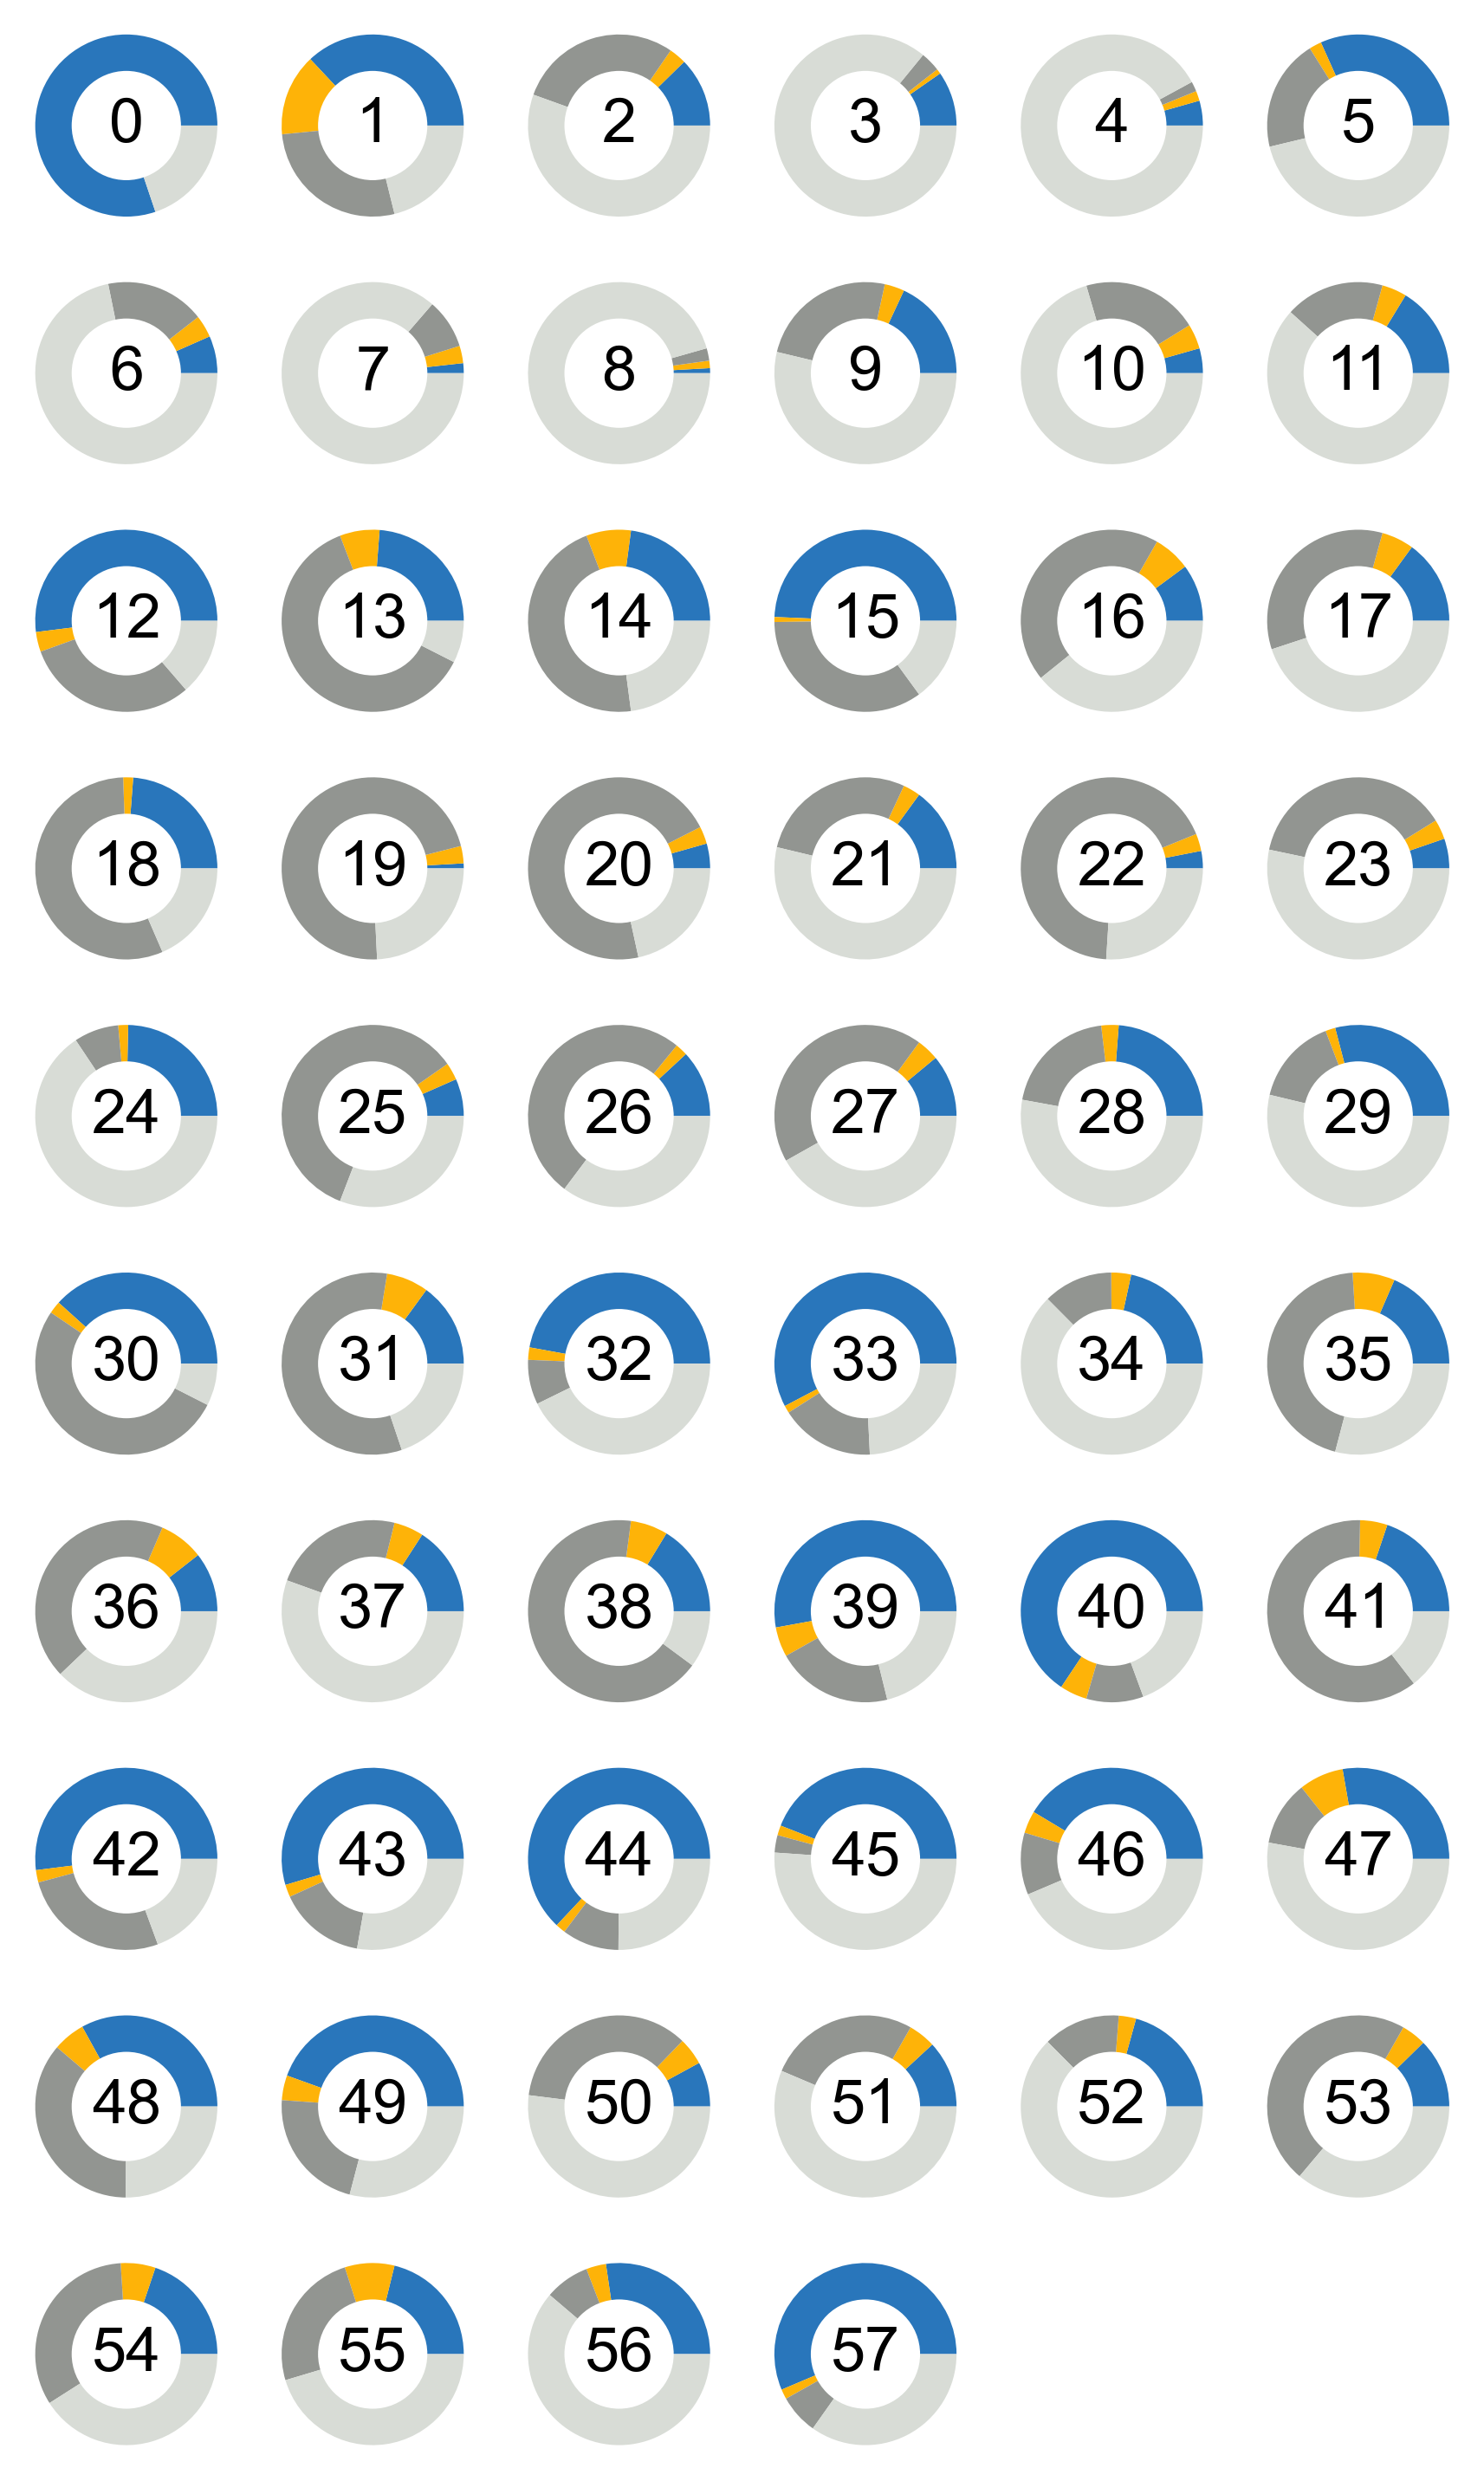

In [38]:
arialfont = {'fontname':'Arial'}

fig, ax = plt.subplots(nrows=10, ncols=6, figsize=(12,20))

colors = ["xkcd:bluish", "xkcd:amber", "xkcd:grey", "xkcd:light grey"]

for i, ax in enumerate(ax.flat):
    if i>=len(phyparts_pies):
        ax.axis('off')
    else:
        ax.pie(phyparts_pies[str(i)], startangle=0, colors=colors)
        centre_circle = plt.Circle((0,0), 0.6, color='black', fc='white',linewidth=0)
        ax.add_artist(centre_circle)
        ax.text(x=0, y=0, s=str(i), horizontalalignment='center', verticalalignment='center', 
                size=36, **arialfont)

plt.tight_layout()
# plt.savefig("../Figures/Concordance-analysis/All-pies.pdf", bbox_inches='tight', 
#             dpi=300, transparent=True)

In [55]:
nuc_astral_newick = "(((((((((Symphoricarpos, Triosteum), Leycesteria), Lonicera)), Heptacodium),(((Dipsacoideae, Valerianoideae), Morinoideae), (Zabelia, Linnaeeae))), Diervillioideae),Adoxaceae),Outgroups);"
nuc_raxml_newick = "(((((((((Symphoricarpos, Triosteum), Lonicera)), Leycesteria), Heptacodium),((((Dipsacoideae, Valerianoideae), Morinoideae), Linnaeeae), Zabelia)), Diervillioideae),Adoxaceae),Outgroups);"
cp_exons_only_newick = "(((((((((Symphoricarpos, Leycesteria), Lonicera)), Triosteum), Heptacodium),((((Dipsacoideae, Valerianoideae), (Morinoideae, Zabelia)), Linnaeeae))), Diervillioideae),Adoxaceae),Outgroups);"
cp_full_newick = "((((((((Triosteum, Leycesteria), Symphoricarpos), Lonicera), Heptacodium),(((Zabelia, Morinoideae), Linnaeeae), (Dipsacoideae, Valerianoideae))), Diervillioideae),Adoxaceae),Outgroups);"
cp_wang_newick = "(((((((Triosteum, Lonicera)), Heptacodium),(((Zabelia, Morinoideae), Linnaeeae), (Dipsacoideae, Valerianoideae))), Diervillioideae),Adoxaceae),Outgroups);"

nuc_astral = toytree.tree(nuc_astral_newick).ladderize()
nuc_raxml = toytree.tree(nuc_raxml_newick).ladderize()
cp_exons_only = toytree.tree(cp_exons_only_newick).ladderize()
cp_full = toytree.tree(cp_full_newick).ladderize()
cp_wang = toytree.tree(cp_wang_newick).ladderize()

In [56]:
canvas = toyplot.Canvas(width=1400, height=350)
ax0 = canvas.cartesian(grid=(1, 5, 0), yshow=False, xshow=False)
ax1 = canvas.cartesian(grid=(1, 5, 1), yshow=False, xshow=False)
ax2 = canvas.cartesian(grid=(1, 5, 2), yshow=False, xshow=False)
ax3 = canvas.cartesian(grid=(1, 5, 3), yshow=False, xshow=False)
ax4 = canvas.cartesian(grid=(1, 5, 4), yshow=False, xshow=False)

ax0.text(a=0, b=13, text="<b>Nuclear (ASTRAL)</b>", color="black", style={"font-family": "helvetica"})
ax1.text(a=0, b=13, text="<b>Nuclear (RAxML)</b>", color="black")
ax2.text(a=0, b=13, text="<b>Chloroplast (exons only)</b>", color="black")
ax3.text(a=0, b=13, text="<b>Chloroplast (full)</b>", color="black")
ax4.text(a=0, b=13, text="<b>Chloroplast (Wang <i>et al</i>., 2020)</b>", color="black")

conflicts = ["Zabelia", "Leycesteria", "Morinoideae"]
color_dict = dict(zip(conflicts, np.repeat(toytree.colors[1], len(conflicts))))

nuc_astral_ecolors = nuc_astral.get_edge_values_from_dict(color_dict)
nuc_raxml_ecolors = nuc_raxml.get_edge_values_from_dict(color_dict)
cp_exons_only_ecolors = cp_exons_only.get_edge_values_from_dict(color_dict)
color_dict.pop("Leycesteria")
cp_wang_ecolors = cp_wang.get_edge_values_from_dict(color_dict)

nuc_astral.draw(edge_widths=2, axes=ax0, node_labels_style={"font-family": "helvetica"})
nuc_raxml.draw(edge_widths=2, axes=ax1, node_labels_style={"font-family": "helvetica"})
cp_exons_only.draw(edge_widths=2, axes=ax2, node_labels_style={"font-family": "helvetica"})
cp_full.draw(edge_widths=2, axes=ax3, node_labels_style={"font-family": "helvetica"})
cp_wang.draw(edge_widths=2, axes=ax4, node_labels_style={"font-family": "helvetica"});

# toyplot.pdf.render(canvas, "../Figures/Misc/All-cartoon-topologies.pdf");

<svg class="toyplot-canvas-Canvas" height="350.0px" id="t57333f550b604cbb862c4b019b0a3763" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 1400.0 350.0" width="1400.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Nuclear (ASTRAL) Valerianoideae Dipsacoideae Morinoideae Linnaeeae Zabelia Triosteum Symphoricarpos Leycesteria Lonicera Heptacodium Diervillioideae Adoxaceae Outgroups Nuclear (RAxML) Valerianoideae Dipsacoideae Morinoideae Linnaeeae Zabelia Triosteum Symphoricarpos Lonicera Leycesteria Heptacodium Diervillioideae Adoxaceae Outgroups Chloroplast (exons only) Zabelia Morinoideae Valerianoideae Dipsacoideae Linnaeeae Leycesteria Symphoricarpos Lonicera Triosteum Heptacodium Diervillioideae Adoxaceae Outgroups Chloroplast (full) Morinoideae Zabelia Linnaeeae Valerianoideae Dipsacoideae Leycesteria Triosteum Symphoricarpos Lonicera Heptacodium Diervillioideae Adoxaceae Outgroups Chloroplast (Wang et al ., 2020) Morinoideae Zabelia Linnaeeae Valerianoideae Dipsacoideae Lonicera Triosteum Heptacodium Diervillioideae Adoxaceae Outgroups

# Portulaca species tree

In [82]:
portulaca_tree = toytree.tree("/Users/iangilman/Dropbox/GitHub_repos/Portulaca_phylogeny/GenBank_data/Ocampo_Portulaca.parts.treefile")

root_taxa = ["Portulaca_oleracea_subsp_granulatostellulata-Chhetri_1065", 
             "Portulaca_pilosa-Nortrup_sn"]
rooting_node = portulaca_tree.get_mrca_idx_from_tip_labels(root_taxa)
rooting_clade = portulaca_tree.get_tip_labels(rooting_node)
portulaca_tree = portulaca_tree.root(rooting_clade)

to_drop = ["Portulaca_quadrifida-Cruse-Sanders_sn", "Portulaca_cf_bicolor_GO-2012-Ocampo_etal_1726",
          "Portulaca_sp_GO-2012-Ocampo_etal_1754", "Portulaca_umbraticola_subsp_umbraticola-Ocampo_etal_1586",
          "Portulaca_umbraticola_subsp_lanceolata-NO-COLLECTOR-INFO", "Portulaca_umbraticola_subsp_coronata-Faircloth_sn",
          "Portulaca_umbraticola_subsp_lanceolata-Ocampo___Columbus_1527", "Portulaca_sp_GO-2012-Burgoyne_7943",
          "Portulaca_pilosa-Ocampo_etal_1718", "Portulaca_amilis-Matthews___Soule_sn", 
           "Portulaca_pilosa-Ocampo_etal_1718", "Portulaca_pilosa-Cerros_2487"]

portulaca_tree = portulaca_tree.drop_tips(names=to_drop).ladderize()

canvas = toyplot.Canvas(width=3600, height=3600, style={"background-color":"white"})

axes = canvas.cartesian(bounds=(100, 3500, 0, 3600))
axes.show = False


tip_labels = [" ".join(tip.split("-")[0].split("_")) for tip in portulaca_tree.get_tip_labels()]

#(x1, x2, y1, y2)
axes.rectangle(-11.5, 22, -0.5, 35.5, opacity=0.25, color=toytree.colors[0])
axes.rectangle(-17.5, 22, 35.5, 62.5, opacity=0.25, color=toytree.colors[1])
axes.rectangle(-17.5, 22, 62.5, 65.5, opacity=0.25, color=toytree.colors[2])
axes.rectangle(-4.5, 22, 65.5, 73.5, opacity=0.25, color=toytree.colors[3])

portulaca_tree.draw(axes=axes, tip_labels=tip_labels,
                      tip_labels_style={"font-size":"40px"},
                      use_edge_lengths=False, edge_widths=10, node_style={"stroke":"black"}, 
                      scalebar=False, layout="right");

<svg class="toyplot-canvas-Canvas" height="3600.0px" id="tff1c199ea2894c29b8beb3012ab9f28d" preserveAspectRatio="xMidYMid meet" style="background-color:white;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 3600.0 3600.0" width="3600.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Portulaca gilliesii Portulaca obtusa Portulaca mucronulata Portulaca perennis Portulaca eruca Portulaca confertifolia Portulaca amilis Portulaca grandiflora Portulaca californica Portulaca suffrutescens Portulaca mexicana Portulaca rzedowskiana Portulaca matthewsii Portulaca pilosa Portulaca pilosa Portulaca halimoides Portulaca smallii Portulaca grandiflora Portulaca tingoensis Portulaca fluvialis Portulaca papulifera Portulaca biloba Portulaca villosa Portulaca sclerocarpa Portulaca rubricaulis Portulaca pusilla Portulaca tuberosa Portulaca massaica Portulaca foliosa Portulaca halimoides Portulaca filifolia Portulaca decipiens Portulaca australis Portulaca pusilla Portulaca elatior Portulaca umbraticola Portulaca oleracea subsp papillatostellulata Portulaca oleracea subsp sativa Portulaca oleracea subsp nitida Portulaca trituberculata Portulaca oleracea subsp granulatostellulata Portulaca oleracea subsp nitida Portulaca oleracea subsp granulatostellulata Portulaca oleracea subsp papillatostellulata Portulaca oleracea subsp nitida Portulaca oleracea subsp papillatostellulata Portulaca canariensis Portulaca oblonga Portulaca lutea Portulaca molokiniensis Portulaca howellii Portulaca johnstonii Portulaca oleracea subsp oleracea Portulaca oleracea subsp impolita Portulaca retusa Portulaca fulgens Portulaca oleracea subsp nicaraguensis Portulaca guanajuatensis Portulaca yecorensis Portulaca ragonesi Portulaca echinosperma Portulaca intraterranea Portulaca rotundifolia Portulaca mucronata Portulaca cryptopetala Portulaca hirsutissima Portulaca oligosperma Portulaca bicolor Portulaca armitii Portulaca digyna Portulaca quadrifida Portulaca wightiana Portulaca constricta Portulaca hereroensis

In [84]:
toyplot.pdf.render(canvas, "/Users/iangilman/Dropbox/GitHub_repos/Portulaca_phylogeny/GenBank_data/Portulaca-phylogeny.pdf", 
                   height="3600px")

In [5]:
canvas = toyplot.Canvas(width=3600, height=3600, style={"background-color":"white"})

axes = canvas.cartesian(bounds=(1000, 3500, 0, 3600))
axes.show = False

cmap = plt.cm.RdYlGn
node_colors = []
node_sizes = []
for s in dips.get_node_values('support', show_root=0, show_tips=0):
    try:
        node_colors.append(mcolors.to_hex(cmap(float(s))))
        node_sizes.append(50)
    except ValueError:
        node_colors.append("white")
        node_sizes.append(0)


ecolors = dips.get_edge_values_from_dict({
    ("Sambucus_pubens", "Viburnum_jamesonii"): mcolors.rgb2hex("xkcd:reddish"),
    ("Triosteum_himalayanum", "Lonicera_pileata"):mcolors.rgb2hex("xkcd:bluish"),
    ("Zabelia_dielsii", "Morina_longifolia"):mcolors.rgb2hex("xkcd:amber"),
    ("Linnaea_borealis", "Abelia_uniflora"):mcolors.rgb2hex("xkcd:purplish"),
    ("Patrina_triloba", "Valeriana_lobata"):mcolors.rgb2hex("xkcd:greenish"),
    ("Dipsacus_fullomum", "Sixalix_farinosa"):mcolors.rgb2hex("xkcd:orangish")})
        
fillwidth = max([len(t) for t in dips.get_tip_labels()])
tip_labels = [label if "Patrina" not in label else label.replace("Patrina", "Patrinia") for label in dips.get_tip_labels()]
tip_labels = [re.sub("_", " ", tip).ljust(fillwidth) for tip in tip_labels]
dips.ladderize().draw(axes=axes, tip_labels=tip_labels, tip_labels_align=True, edge_colors=ecolors,
                      tip_labels_style={"font-size":"40px"},
                      node_labels=None, node_sizes=node_sizes, node_colors=node_colors, 
                      use_edge_lengths=False, edge_widths=10, node_style={"stroke":"black"}, 
                      scalebar=False, layout="left");

<svg class="toyplot-canvas-Canvas" height="3600.0px" id="td60ddfe35a00453b86916b613a46ec86" preserveAspectRatio="xMidYMid meet" style="background-color:white;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 3600.0 3600.0" width="3600.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Lomelosia albocinta Sixalix farinosa Pycnocomon canus Pteracephalodes hookeri Bassecoia siamensis Dipsacus fullomum Cephalaria gigantea Succisa pratensis Knautia macedonica Triplostegia grandulifera Plectritis congesta Valeriana lobata Centranthus ruber Valeriana microphylla Fedia cornucopiae Nardostachys jatamansi Patrinia triloba Cryptothladia kokonorica Morina longifolia Acanthocalyx nepalensis ssp delevaya Abelia uniflora Diabelia tetrasepala Kolkwitzia amabilis Dipelta floribunda Vesalea coriacea Linnaea borealis Zabelia dielsii Zabelia tyaihyoni Lonicera maackii Lonicera quinquelocuaris Lonicera floribunda Lonicera xylosteum Lonicera tatarica Lonicera orientalis Lonicera standishii Lonicera fragrantissima Lonicera ferdinandi Lonicera gynochlamydea Lonicera pileata Lonicera periclymenum Lonicera caerulea Triosteum himalayanum Symphoricarpos occidentalis Leycesteria formosa Heptacodium miconioides Weigela florida Diervilla sessilifolia Viburnum coriaceum Viburnum vernicosum Viburnum luzonicum Viburnum jamesonii Viburnum lantenoides Viburnum taiwanianum Viburnum lutescens Viburnum rhytidophyllum Sambucus pubens Sambucus cerulea Sambucus gaudichaudiana Paracryphia alticola Ilex crenata